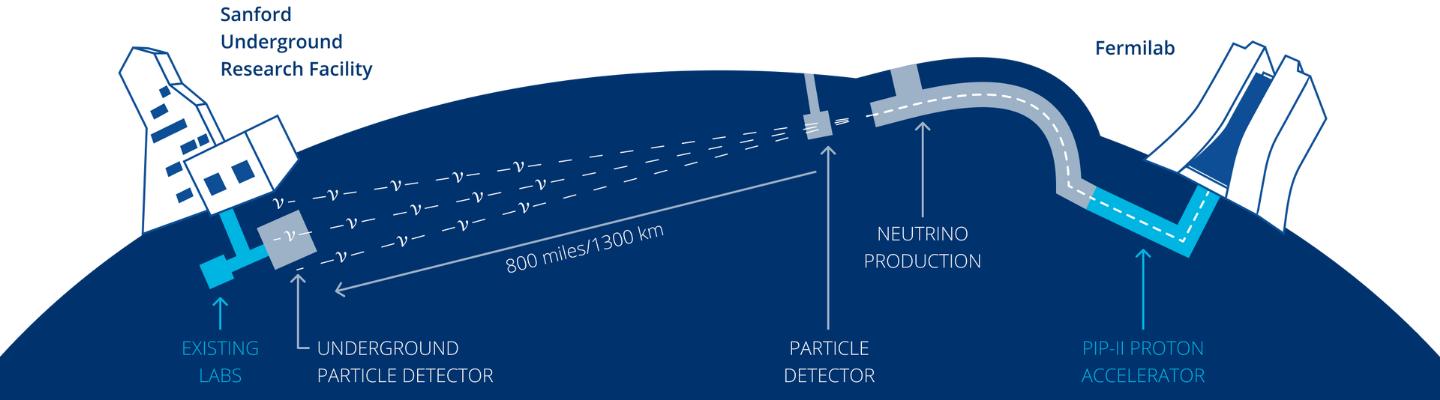

# <a id='toc1_'></a>[Parameter evaluation of clustering method for Real Data from the PDHD Detector](#toc0_)
This notebook focuses on the run 32974, collection plane, APA2 (TPC3).

In RUN_test_event_run.ipynb we analyzed the possibility of using a sequential clustering and then linear regression pattern finding inside the clusters. In this notebook we want to identify if there is a viable solution to find the optimal hyperparameters for these operations.

**Table of contents**<a id='toc0_'></a>    
- [Parameter evaluation of clustering method for Real Data from the PDHD Detector](#toc1_)    
  - [Loading the libraries, files and style of the notebook](#toc1_1_)    
  - [Characteristics of a single run (collection plane) hits of a single TPC.](#toc1_2_)    
  - [Looking into thresholds and noise removal](#toc1_3_)    
  - [Clustering and tracking](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Loading the libraries, files and style of the notebook](#toc0_)

In [35]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [36]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../custom.css", "r").read()
    return HTML(styles)

In [37]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [38]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [39]:
#In this notebook we will try to do some more statystics and use all of them
events = df_32974.event.unique()
print(f"Event {events}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [40]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [41]:
plane=2

def make_title(run, event, cuts="no cuts"):
    return f"Run {run} | Event {event} | Plane {plane} | {cuts}"

## <a id='toc1_2_'></a>[Characteristics of a single run (collection plane) hits of a single TPC.](#toc0_)

In [42]:
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974
tps_32974.run_name = "Cosmic run 32974"

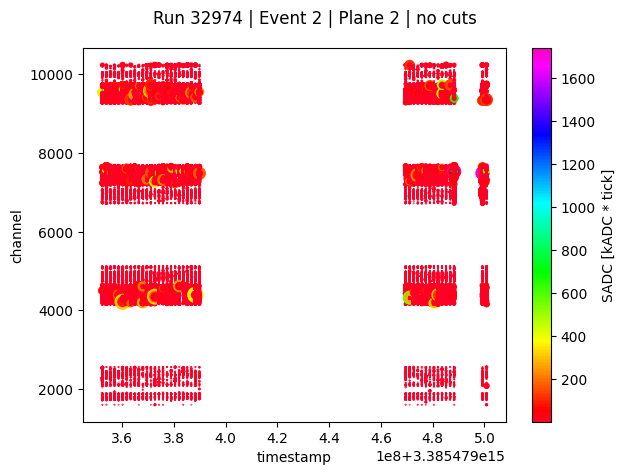

In [9]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
tps.run_name = "Cosmic run 32974"
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(make_title(tps['run'].unique()[0], plane))
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [10]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 3476.412, mean 4.431609466048282, std deviation 26.564154887469076
TP_PeakADC: Minimum value 61, maximum 15886, mean 393.2983097260657, std deviation 445.1967497902622
TP_TOT: Minimum value 1, maximum 1171, mean 13.815287995808866, std deviation 18.607527684417374


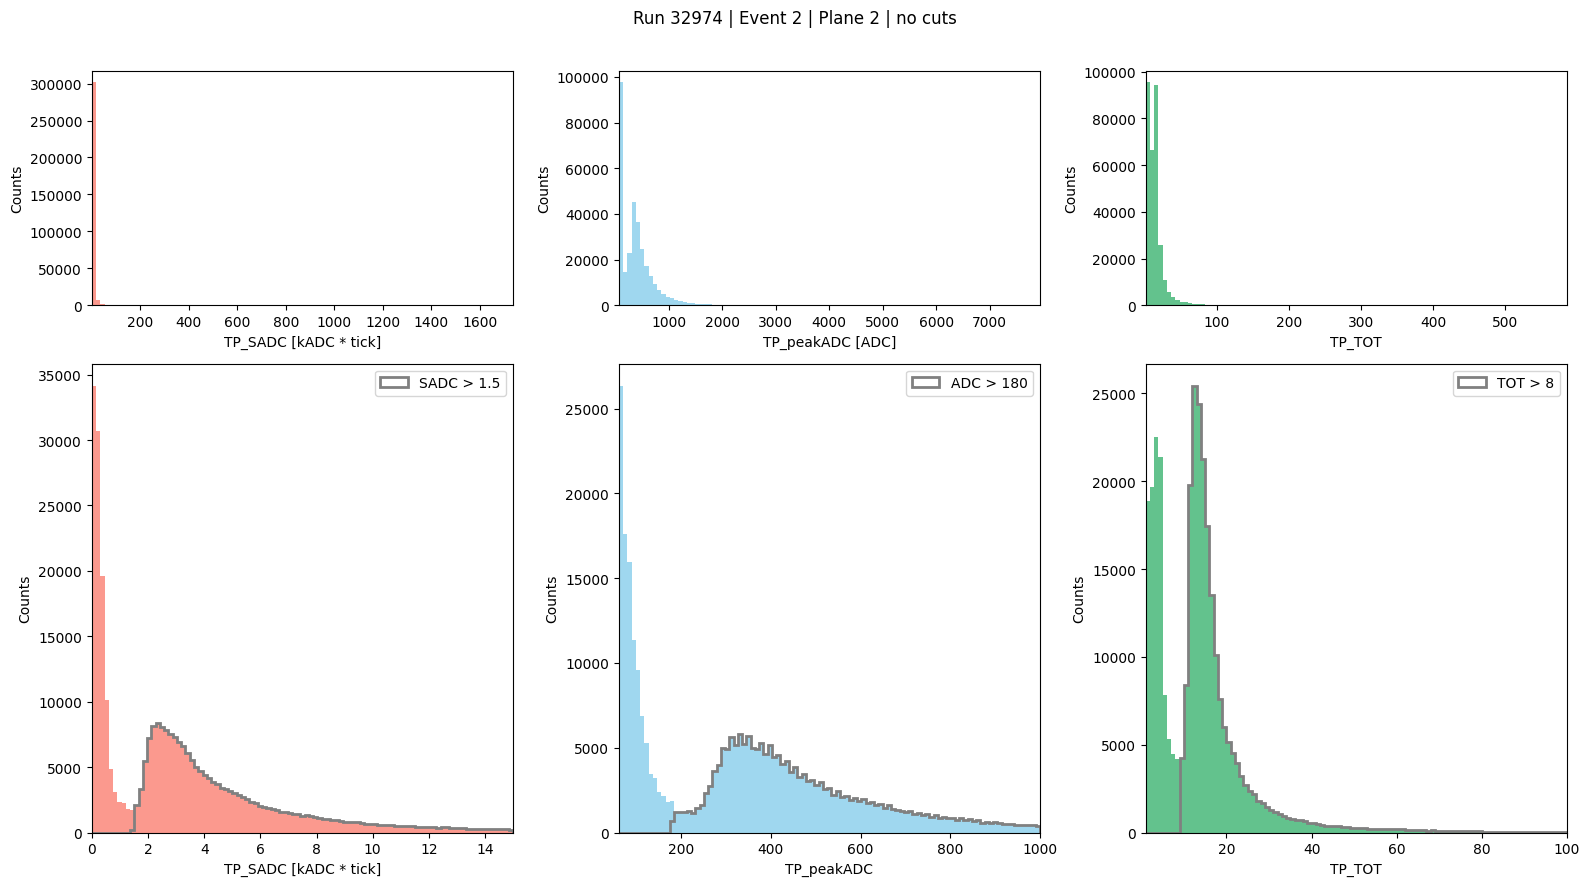

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(make_title(tps['run'].unique()[0], plane))

# 1. TP_SADC
bins_sadc = np.linspace(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3, 100)
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=bins_sadc, alpha=0.8, color='salmon')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].set_xlim(bins_sadc[0], bins_sadc[-1])

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 15)
tps_zoom_sadc = tps[mask_sadc]
bins_sadc_zoom = np.linspace(0, 15, 100)
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=bins_sadc_zoom, alpha=0.8, color='salmon')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(bins_sadc_zoom[0], bins_sadc_zoom[-1])

threshold_sadc = 1.5
sadc_cut = tps_zoom_sadc[tps_zoom_sadc['TP_SADC']/1e3 > threshold_sadc]
axs[1, 0].hist(sadc_cut['TP_SADC']/1e3, bins=bins_sadc_zoom, histtype='step', color='gray', linewidth=2, label='SADC > 1.5')
axs[1, 0].legend()

# 2. TP_peakADC
bins_adc = np.linspace(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2, 100)
axs[0, 1].hist(tps['TP_peakADC'], bins=bins_adc, alpha=0.8, color='skyblue')
axs[0, 1].set_xlabel('TP_peakADC [ADC]')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(bins_adc[0], bins_adc[-1])

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
bins_adc_zoom = np.linspace(61, 1000, 100)
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=bins_adc_zoom, alpha=0.8, color='skyblue')
axs[1, 1].set_xlabel('TP_peakADC')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(bins_adc_zoom[0], bins_adc_zoom[-1])

threshold_adc = 180
adc_cut = tps_zoom_adc[tps_zoom_adc['TP_peakADC'] > threshold_adc]
axs[1, 1].hist(adc_cut['TP_peakADC'], bins=bins_adc_zoom, histtype='step', color='gray', linewidth=2, label='ADC > 180')
axs[1, 1].legend()

# 3. TP_TOT
bins_tot = np.linspace(tps['TP_TOT'].min(), tps['TP_TOT'].max()/2, 100)
axs[0, 2].hist(tps['TP_TOT'], bins=bins_tot, alpha=0.8, color='mediumseagreen')
axs[0, 2].set_xlabel('TP_TOT')
axs[0, 2].set_ylabel('Counts')
axs[0, 2].set_xlim(bins_tot[0], bins_tot[-1])

mask_tot = (tps['TP_TOT'] >= 1) & (tps['TP_TOT'] <= 100)
tps_zoom_tot = tps[mask_tot]
bins_tot_zoom = np.linspace(1, 100, 100)
axs[1, 2].hist(tps_zoom_tot['TP_TOT'], bins=bins_tot_zoom, alpha=0.8, color='mediumseagreen')
axs[1, 2].set_xlabel('TP_TOT')
axs[1, 2].set_ylabel('Counts')
axs[1, 2].set_xlim(bins_tot_zoom[0], bins_tot_zoom[-1])

threshold_tot = 8
tot_cut = tps_zoom_tot[tps_zoom_tot['TP_TOT'] > threshold_tot]
axs[1, 2].hist(tot_cut['TP_TOT'], bins=bins_tot_zoom, histtype='step', color='gray', linewidth=2, label='TOT > 8')
axs[1, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

    Apparently the same cuts we used for one single event work in this case

Event duration: 1.6919 s


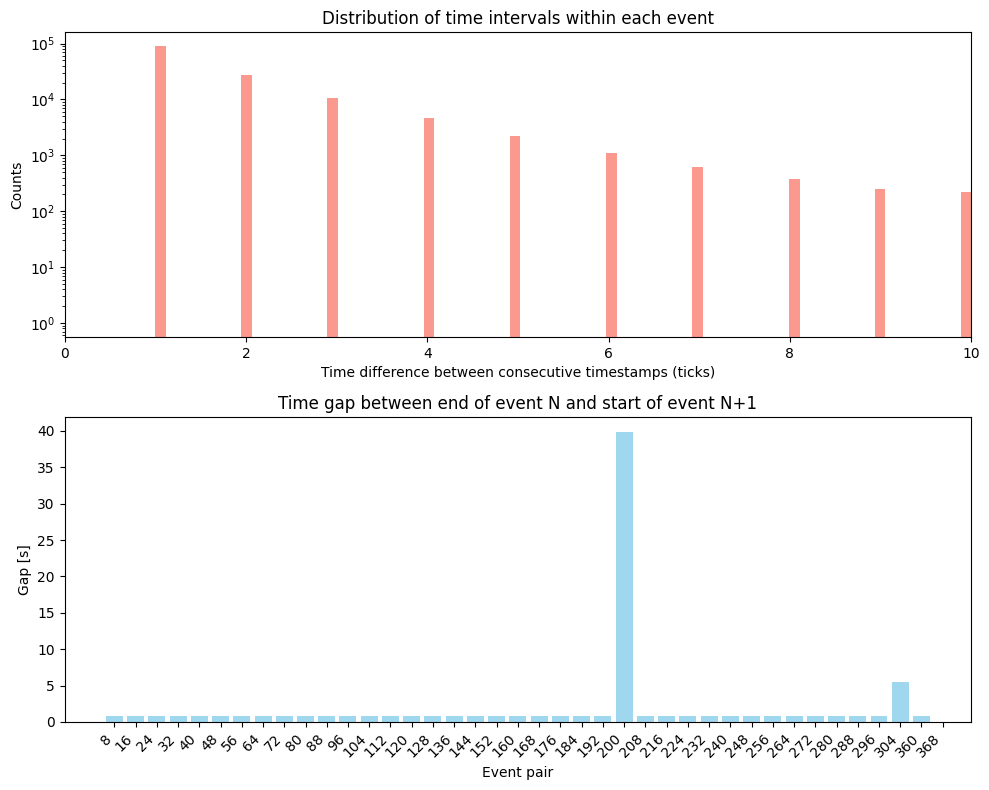

In [12]:
# Store intra-event intervals and inter-event gaps
intra_event_diffs = []
event_firsts = []
event_lasts = []
event_durations_seconds = []

for ev in events:
    ev_df = tps[tps.event == ev]
    ts = np.sort(ev_df["TP_peakT"].unique())
    if len(ts) > 1:
        intra_event_diffs.append(np.diff(ts))
        duration_ticks = ts.max() - ts.min()
        duration_seconds = duration_ticks * 500 / 1e9 #each tick corresponds to 500 ns
        event_durations_seconds.append(duration_seconds)
    event_firsts.append(ts[0])
    event_lasts.append(ts[-1])

# Flatten intra-event diffs for global histogram
intra_event_flat = np.concatenate(intra_event_diffs)

# Compute inter-event gaps
event_firsts = np.array(event_firsts)
event_lasts = np.array(event_lasts)
inter_event_gaps = event_firsts[1:] - event_lasts[:-1]
inter_event_gaps_seconds = inter_event_gaps * 500 / 1e9

print(f"Event duration: {np.mean(intra_event_flat):.4f} s")

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].hist(intra_event_flat, bins=int(2*np.sqrt(len(intra_event_flat))), color='salmon', alpha=0.8, log=True) #y axis in log scale
axs[0].set_title('Distribution of time intervals within each event')
axs[0].set_xlabel('Time difference between consecutive timestamps (ticks)')
axs[0].set_ylabel('Counts')
axs[0].set_xlim(0, 10)

# Bar plot with custom labels for event pairs
axs[1].bar(range(len(inter_event_gaps_seconds)), inter_event_gaps_seconds, color='skyblue', alpha=0.8)
axs[1].set_title('Time gap between end of event N and start of event N+1')
axs[1].set_xlabel('Event pair')
axs[1].set_ylabel('Gap [s]')
axs[1].set_xticks(range(len(events)))
axs[1].set_xticklabels(events, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Looking into thresholds and noise removal](#toc0_)

In [13]:
def plot_TPC_activity(tp_df, thresh, thresh_type="TP_peakADC", vmin=None, vmax=None, show_counts=True):  
    """
    Creates scatter plots showing TP distribution across APAs with optional bar charts for TP counts. 
    Scatter plot point sizes are proportional to TP_TOT/10. Scatter plot colors represent TP_SADC values using 'gist_rainbow' colormap
    Data is filtered based on specified threshold criteria to remove noise.
    Creates 2x2 subplot grid for the 4 APAs in ProtoDUNE. Requires global variable 'apa_ranges' containing APA channel ranges

    ----------
    tp_df : pandas.DataFrame
        DataFrame containing trigger primitive data
        
    thresh : float
        Threshold value for filtering TPs. 
        
    thresh_type : str, optional
        Type of threshold to apply for filtering. Default is "TP_peakADC".
        Options:
        - "TP_peakADC": Filter by peak ADC value
        - "TP_TOT": Filter by time over threshold
        - "TP_SADC": Filter by sum ADC (divided by 1e3 for kADC units)
        
    vmin : float, optional
        Minimum value for colorbar scale in scatter plots. If None, uses data minimum.
        
    vmax : float, optional
        Maximum value for colorbar scale in scatter plots. If None, uses data maximum.
        
    show_counts : bool, optional
        Whether to display bar chart showing TP counts per APA. Default is True.
    """
    global apa_ranges 
    title_prefix = "TP Activity per APA"
    # Filter based on the threshold type
    if thresh_type == "TP_peakADC":
        filtered = tp_df[tp_df.TP_peakADC > thresh]
    elif thresh_type == "TP_TOT":
        filtered = tp_df[tp_df.TP_TOT > thresh]
    elif thresh_type == "TP_SADC":
        filtered = tp_df[tp_df.TP_SADC / 1e3 > thresh]
    else:
        raise ValueError(f"Unknown threshold type: {thresh_type}")

    print(f"Threshold ({thresh_type}): {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name if hasattr(tp_df, 'run_name') else "unknown_run"
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh_type} > {thresh})"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC,
            cmap="gist_rainbow",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color='steelblue')
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({thresh_type} > {thresh})")
        plt.show()

Threshold (TP_SADC): 1.5 (TPs: 17103, Retaining 67.33% of raw TP)


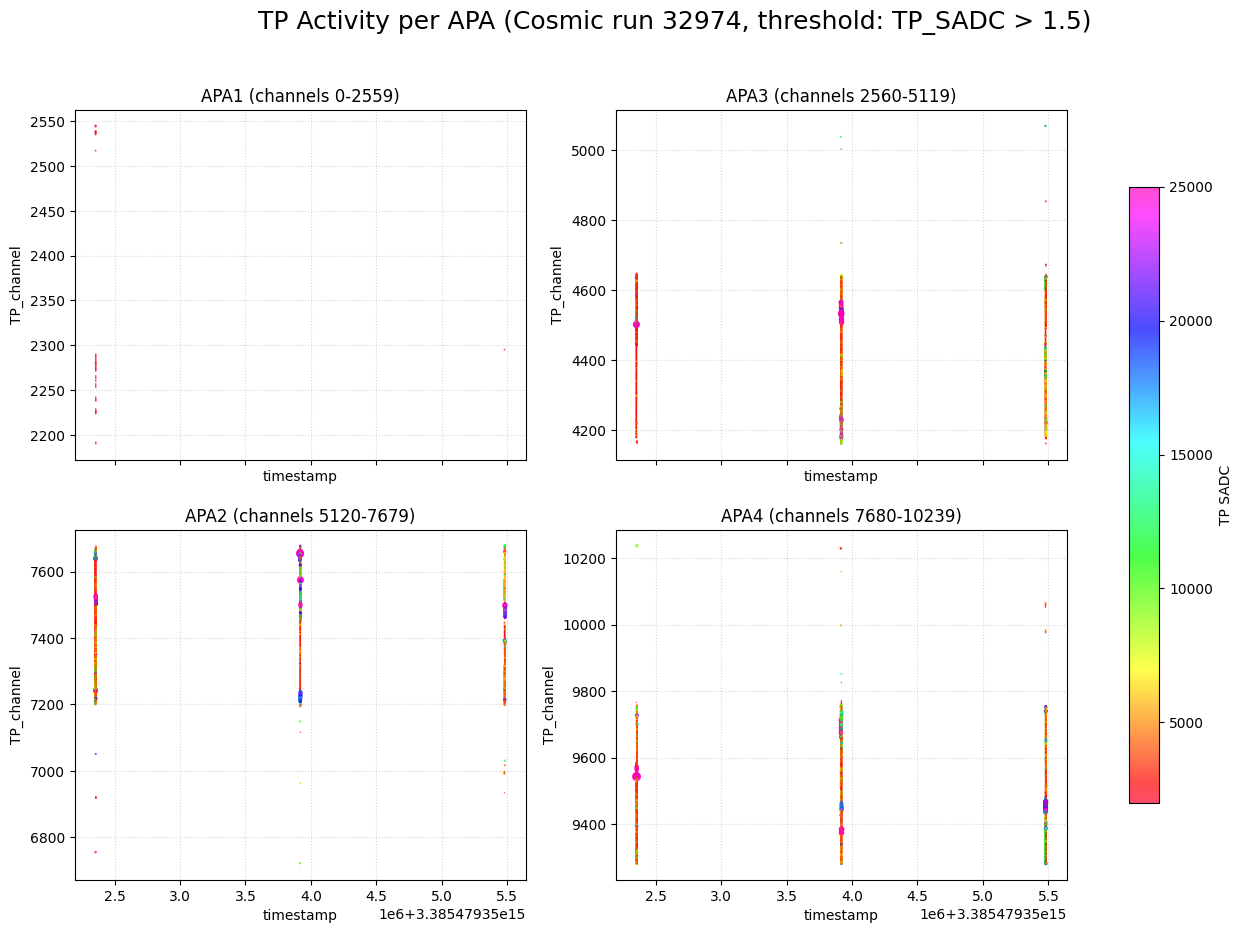

Threshold (TP_peakADC): 180 (TPs: 17406, Retaining 68.53% of raw TP)


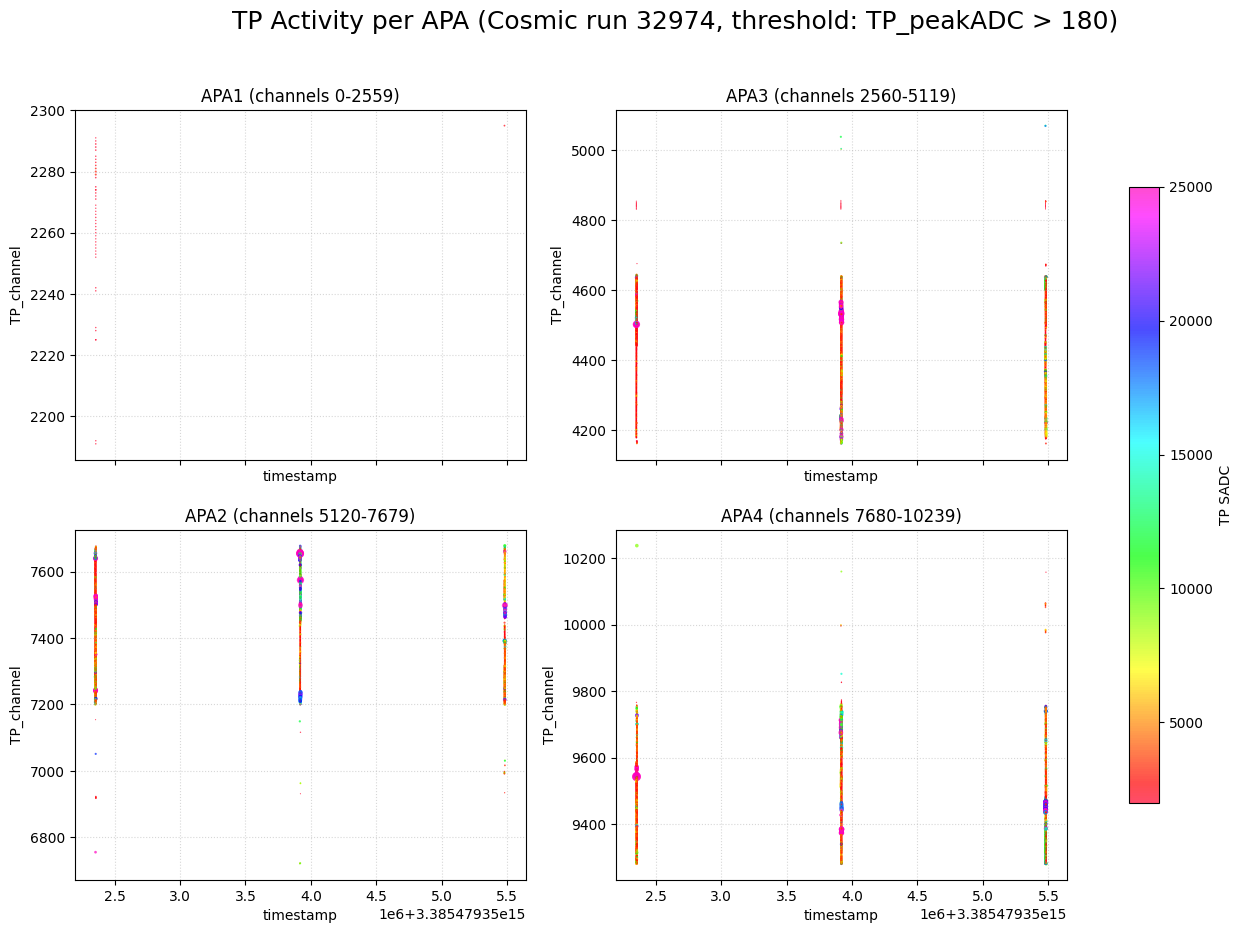

Threshold (TP_TOT): 8 (TPs: 17510, Retaining 68.94% of raw TP)


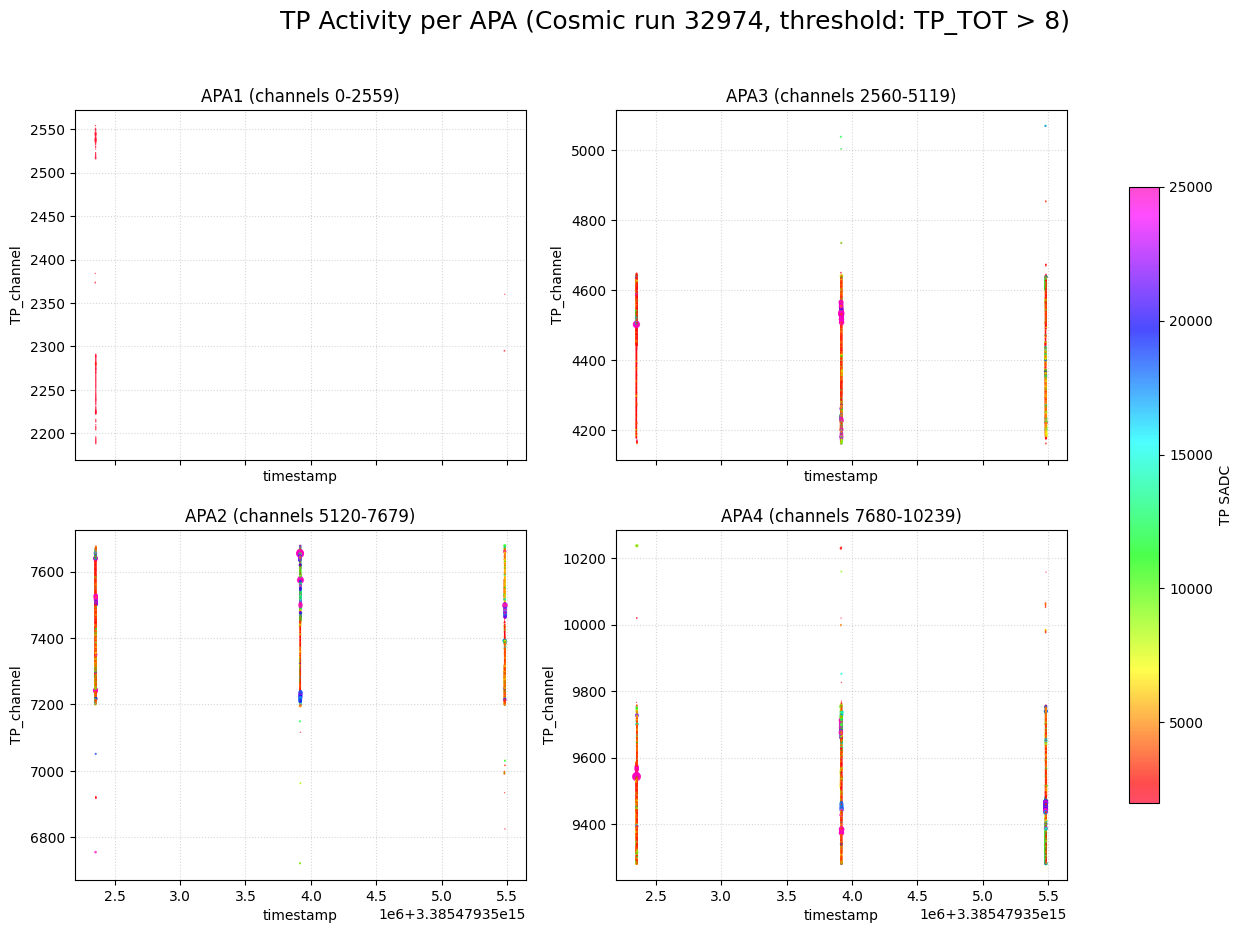

In [14]:
mask = (tps['event'] < 25)
tps_subset = tps[mask]
tps_subset.run_name = tps.run_name

# For SADC threshold
plot_TPC_activity(tps_subset, threshold_sadc, 
            vmin=2000, vmax=25000, thresh_type="TP_SADC", show_counts=False)

# For ADC threshold
plot_TPC_activity(tps_subset, threshold_adc, 
            vmin=2000, vmax=25000, thresh_type="TP_peakADC", show_counts=False)

# For TOT threshold
plot_TPC_activity(tps_subset, threshold_tot, 
            vmin=2000, vmax=25000, thresh_type="TP_TOT", show_counts=False)

- Big dots are just particles perpedincular to one single channel and therefore releasing a lot of energy in that single channel.
- Because the peakT are so different it's impossible to see any tracks inside the events

In [44]:
filtered_tps= tps_subset[tps_subset.TP_SADC / 1e3 > threshold_sadc]
filtered_APA2=filtered_tps[(filtered_tps.TP_channel>=apa_ranges["APA2"][0]) & (filtered_tps.TP_channel<apa_ranges["APA2"][1])]
filtered_APA2.run_name = tps.run_name

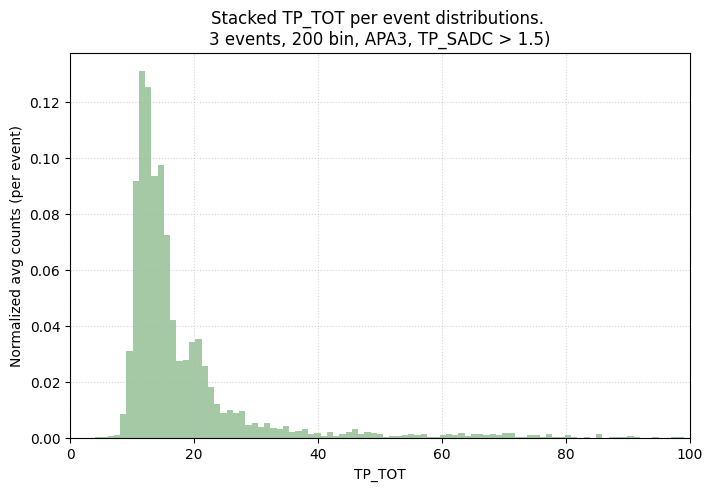

In [16]:
"""
Event-by-Event TP_TOT Distribution Analysis for APA3

This cell performs a detailed statistical analysis of Time Over Threshold (TP_TOT) distributions across multiple cosmic ray events in APA3.

Analysis Strategy:
-----------------
Instead of combining all TP_TOT values from multiple events into a single histogram (which can
smooth out important features), this analysis:

1. Calculates individual normalized histograms for each event
2. Computes the average normalized distribution across all events
3. Creates a 2D heatmap showing TP_TOT distributions per event

Motivation:
---------------------
- Different cosmic ray events may be dominated by different track types or signal populations: aggregating all TP_TOT values can lead to merging and overlapping peaks, 
resulting in a smoother distribution that obscures distinct features.
- This approach wants to reveal common structural features across events

Binning: 200 bins from 0 to 100 TP_TOT units for high resolution
"""

events = np.sort(filtered_APA2['event'].unique())
bins = np.linspace(0, 100, 100)  # 200 bin da 0 a 100
#: in alcuni eventi possono dominare certe tracce o tipologie di segnali che producono un picco, in altri eventi un’altra popolazione. 
# Sommando tutto, i picchi possono “mescolarsi” e sovrapporsi, risultando in una distribuzione più smooth e larga senza due massimi evidenti.

# ================= TP_TOT =================
# Invece di sommare tutte le TP_TOT di 88 eventi insieme, calcola la distribuzione per ogni evento e poi somma (“stacked histogram”) o fai la media delle distribuzioni normalizzate.
# Questo evita che eventi molto “ricchi” dominino la statistica, e fa emergere strutture comuni.
all_event_histos_tot = []
for ev in events:
    dat = filtered_APA2[filtered_APA2['event'] == ev]['TP_TOT']
    counts, _ = np.histogram(dat, bins=bins)
    if counts.sum() > 0:
        counts = counts / counts.sum()
    all_event_histos_tot.append(counts)
mean_histo_tot = np.mean(all_event_histos_tot, axis=0)

plt.figure(figsize=(8,5))
plt.bar((bins[:-1]+bins[1:])/2, mean_histo_tot, width=np.diff(bins), color='darkseagreen', alpha=0.8)
plt.xlabel("TP_TOT")
plt.ylabel("Normalized avg counts (per event)")
plt.title(f"Stacked TP_TOT per event distributions. \n{len(events)} events, 200 bin, APA3, TP_SADC > {threshold_sadc})")
plt.xlim(0, 100)
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

Most of the events seem to be between 11-18, the bimodial distribution that is clear in the case of **RUN_test_event_run.ipynb** is not visibile over here.

## <a id='toc1_4_'></a>[Clustering and tracking](#toc0_)

Using Optuna package for parameters optimization and some parallelization

In [45]:
# Suddivisione per TP_TOT
space_like = filtered_APA2[filtered_APA2["TP_TOT"] < 20]
time_like = filtered_APA2[(filtered_APA2["TP_TOT"] >= 20)]

# Prepare features
X_time = time_like[['TP_peakT', 'TP_channel']].values
X_space = space_like[['TP_peakT', 'TP_channel']].values

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from concurrent.futures import ThreadPoolExecutor

def search_best_dbscan(X, eps_grid, min_samples_grid):
    """Search the best DBSCAN hyperparameters for clustering X."""
    best_score = -1
    best_params = None
    best_n_clusters = None

    for eps in eps_grid:
        for min_samples in min_samples_grid:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            labels = db.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters > 1:
                try:
                    score = metrics.silhouette_score(X, labels)
                except Exception:
                    score = -1
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_n_clusters = n_clusters
    return {
        "best_eps": best_params[0] if best_params else None,
        "best_min_samples": best_params[1] if best_params else None,
        "best_score": best_score if best_score > -1 else None,
        "n_clusters": best_n_clusters if best_n_clusters else None,
    }

def process_event(event, df, eps_grid, min_samples_grid):
    """Process one event for DBSCAN grid search on a given dataframe."""
    sel = df[df['event'] == event].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min()
    X = sel[['TP_peakT', 'TP_channel']].values
    result = search_best_dbscan(X, eps_grid, min_samples_grid)
    result['event'] = event
    return result

def run_dbscan_search(df, eps_grid, min_samples_grid):
    """Run grid search for all events in df."""
    events = np.unique(df['event'])
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda ev: process_event(ev, df, eps_grid, min_samples_grid), events))
    return pd.DataFrame(results)

# --- Hyperparameter Search Space ---
eps_grid = np.arange(5, 100, 25)
min_samples_grid = np.arange(2, 20, 1)

# Example usage:
# For time-like features
results_time = run_dbscan_search(time_like, eps_grid, min_samples_grid)
print("\nSummary table of best DBSCAN hyperparameters per event (TIME-like):")
print(results_time)

# For space-like features
results_space = run_dbscan_search(space_like, eps_grid, min_samples_grid)
print("\nSummary table of best DBSCAN hyperparameters per event (SPACE-like):")
print(results_space)


Summary table of best DBSCAN hyperparameters per event (TIME-like):
   best_eps  best_min_samples  best_score  n_clusters  event
0        30                 2    0.406243          45      8
1        80                14    0.297439           3     16
2        80                 2    0.386038          12     24

Summary table of best DBSCAN hyperparameters per event (SPACE-like):
   best_eps  best_min_samples  best_score  n_clusters  event
0        80                16    0.567473           5      8
1        80                14    0.677681           6     16
2        80                 6    0.530604           6     24


In [64]:
def assign_dbscan_clusters_per_event(df, results_df, event_col='event', x_col='TP_peakT', y_col='TP_channel'):
    """
    Assigns DBSCAN cluster labels to each event in df using the best parameters from results_df.
    Returns a copy of df with a new column 'cluster'.
    """
    df = df.copy()
    df['cluster'] = -1  # Default: noise
    events = np.unique(df[event_col])
    for ev in events:
        best = results_df[results_df[event_col] == ev]
        if best.empty or np.isnan(best['best_eps'].values[0]) or np.isnan(best['best_min_samples'].values[0]):
            continue  # skip event with no good DBSCAN params
        eps = best['best_eps'].values[0]
        min_samples = int(best['best_min_samples'].values[0])
        sel = df[df[event_col] == ev]
        X = sel[[x_col, y_col]].values
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        # Assign cluster labels
        df.loc[sel.index, 'cluster'] = db.labels_
    return df

# Assign clusters to space_like
space_like_with_clusters = assign_dbscan_clusters_per_event(space_like, results_space,
                                                           event_col='event', x_col='TP_peakT', y_col='TP_channel')

# Assign clusters to time_like
time_like_with_clusters = assign_dbscan_clusters_per_event(time_like, results_time,
                                                          event_col='event', x_col='TP_peakT', y_col='TP_channel')

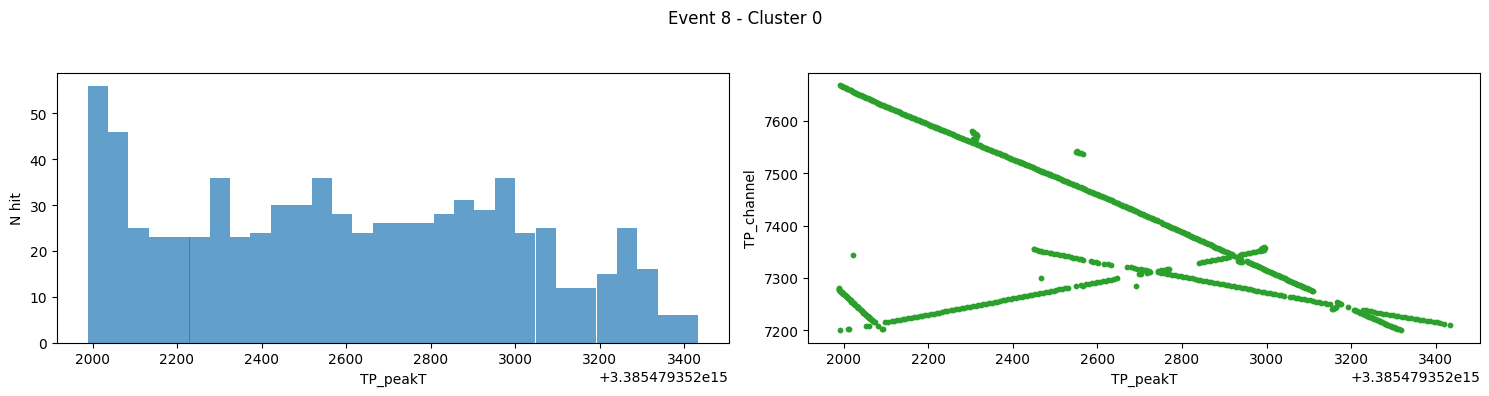

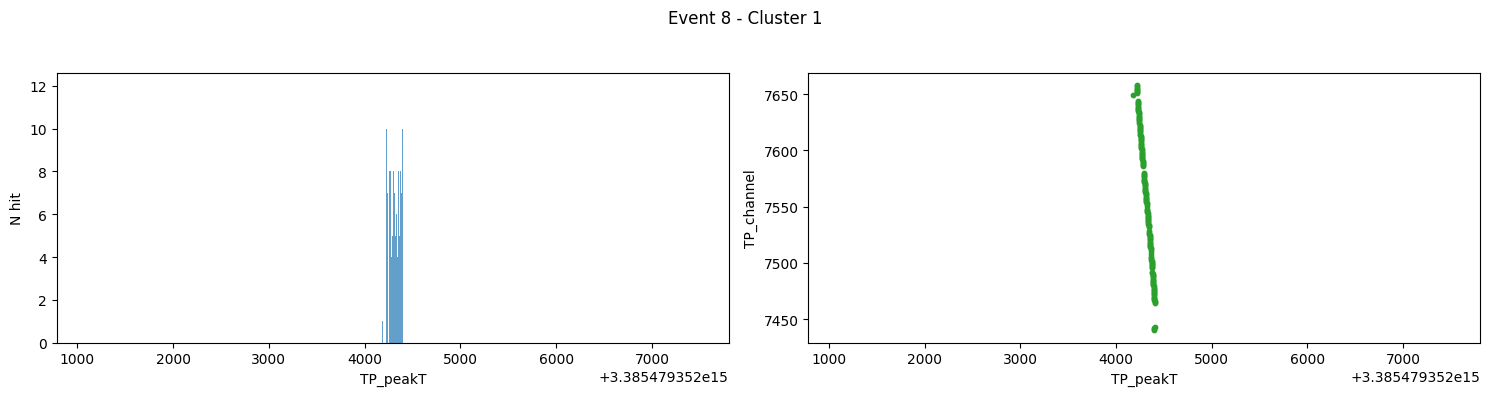

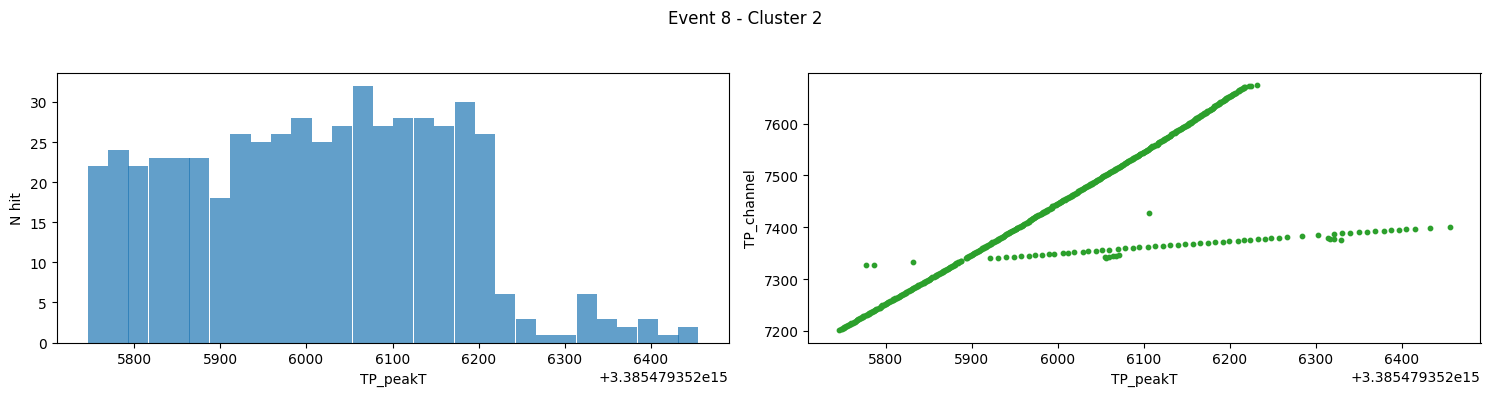

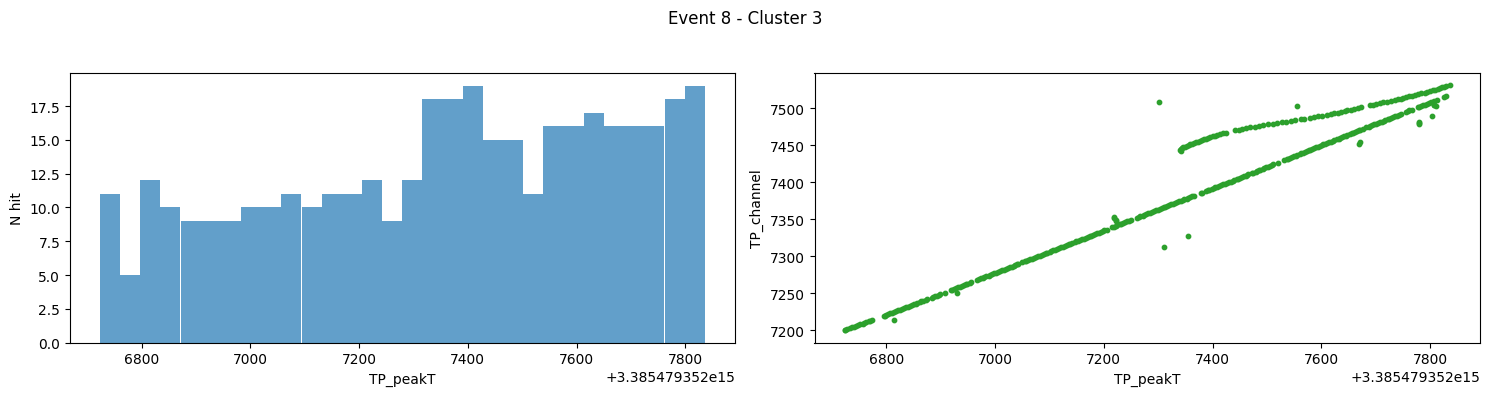

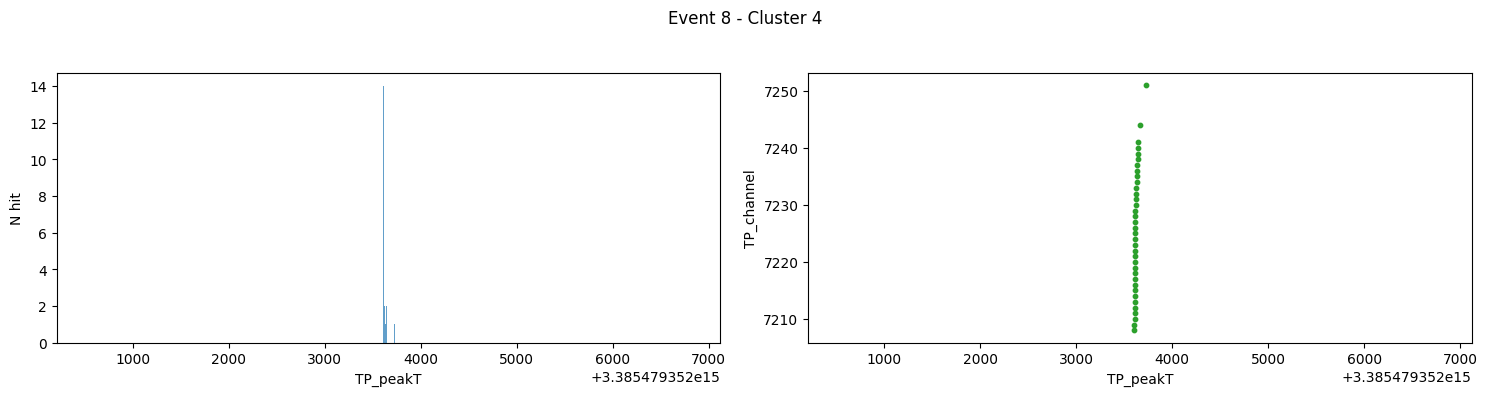

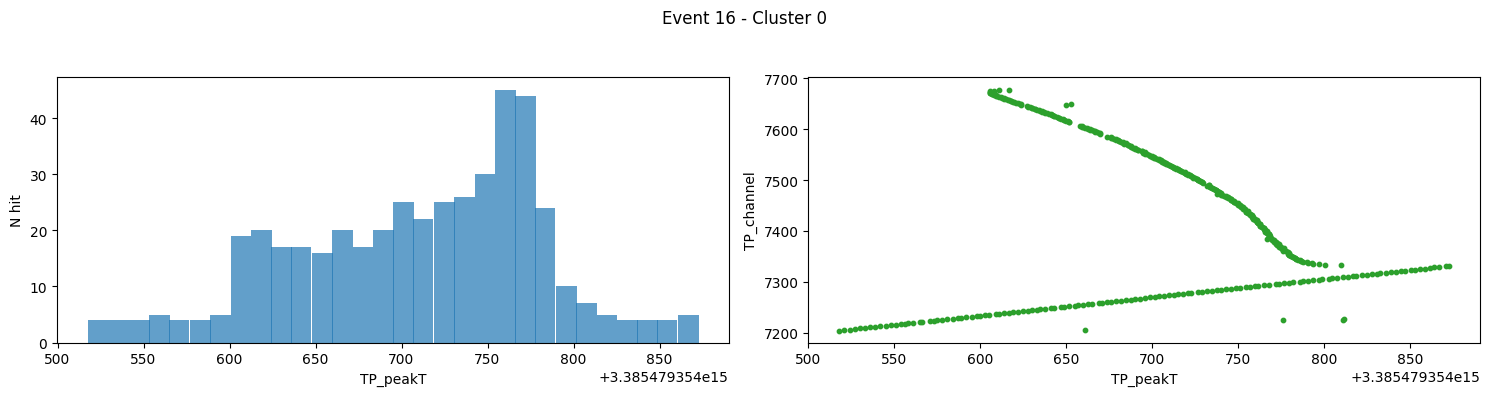

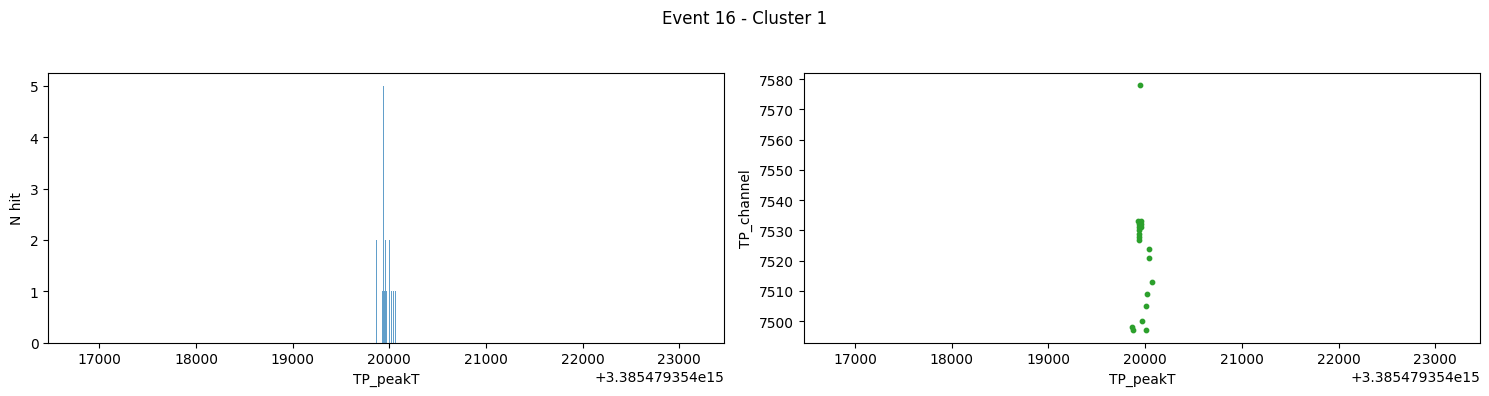

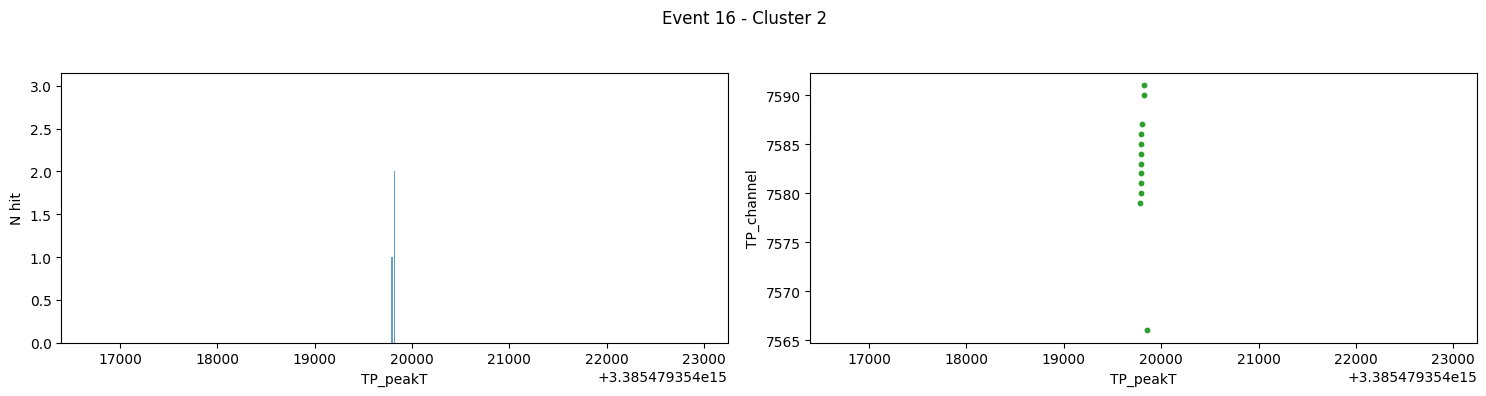

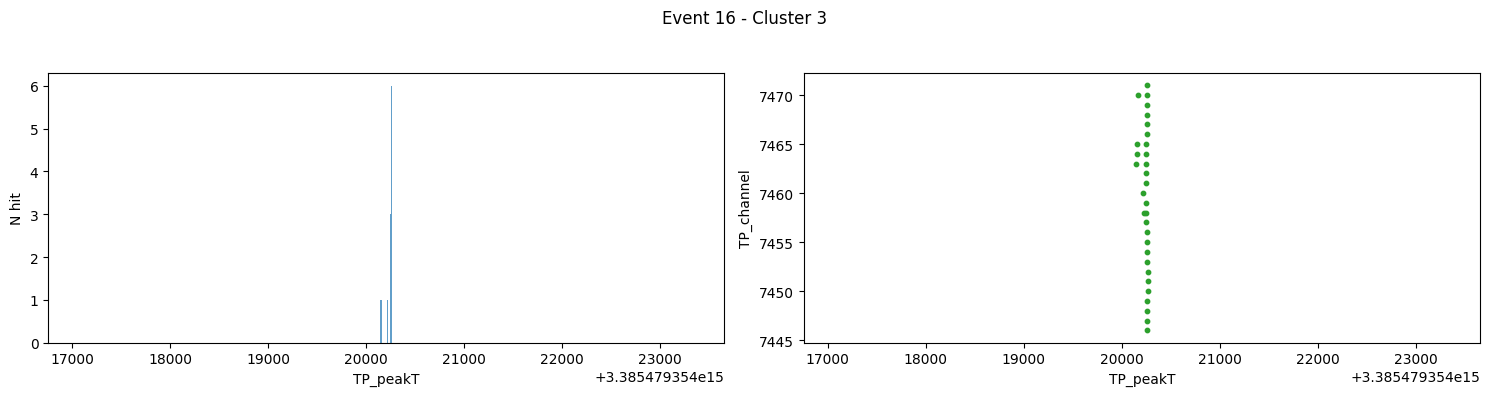

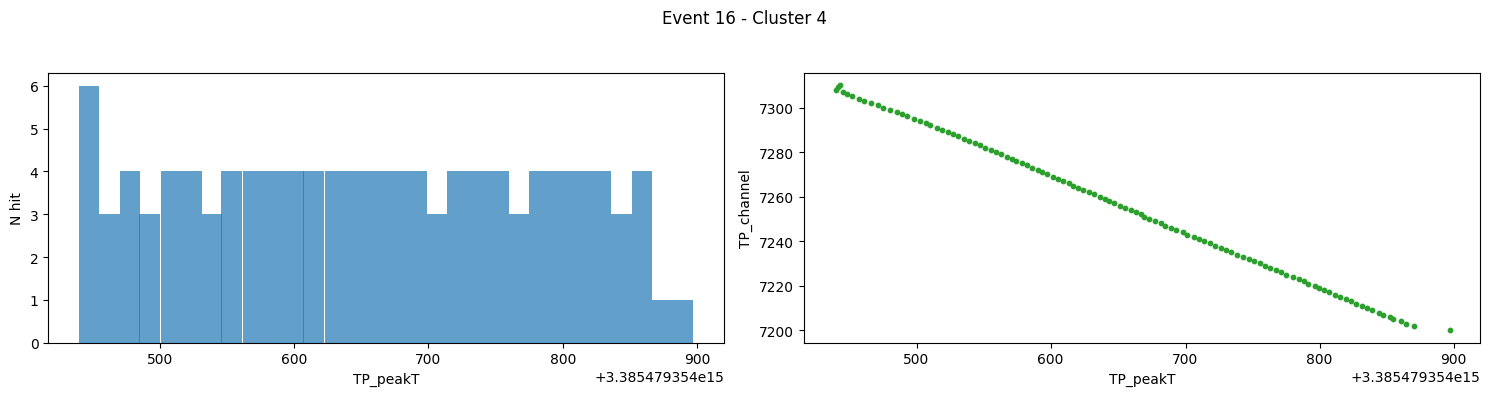

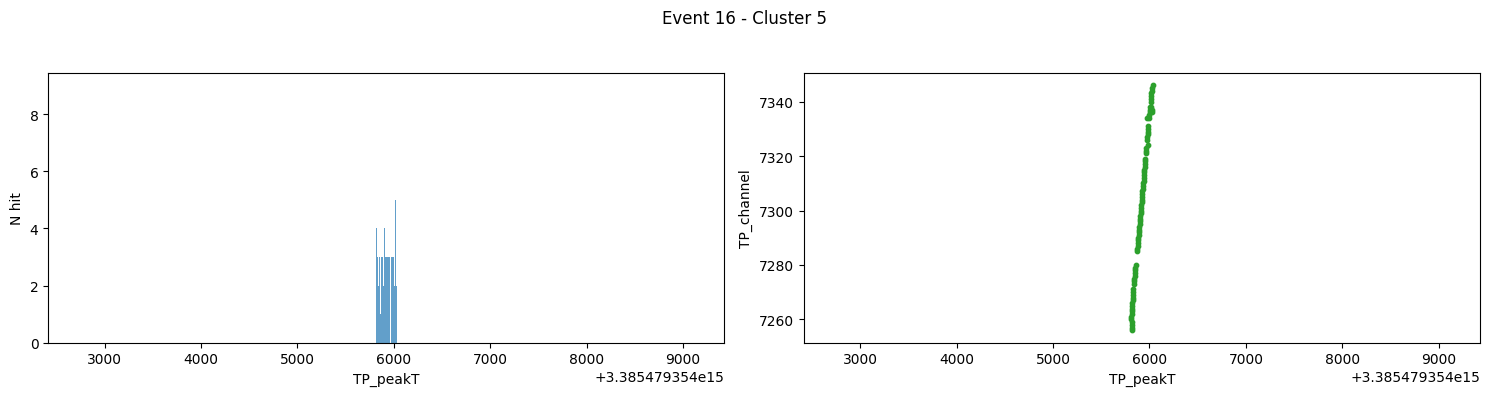

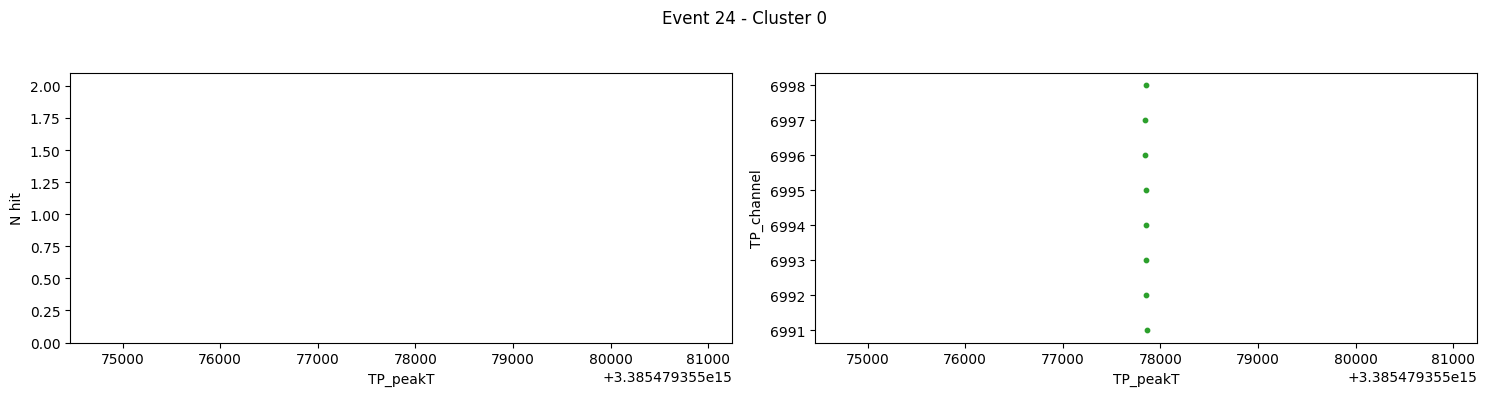

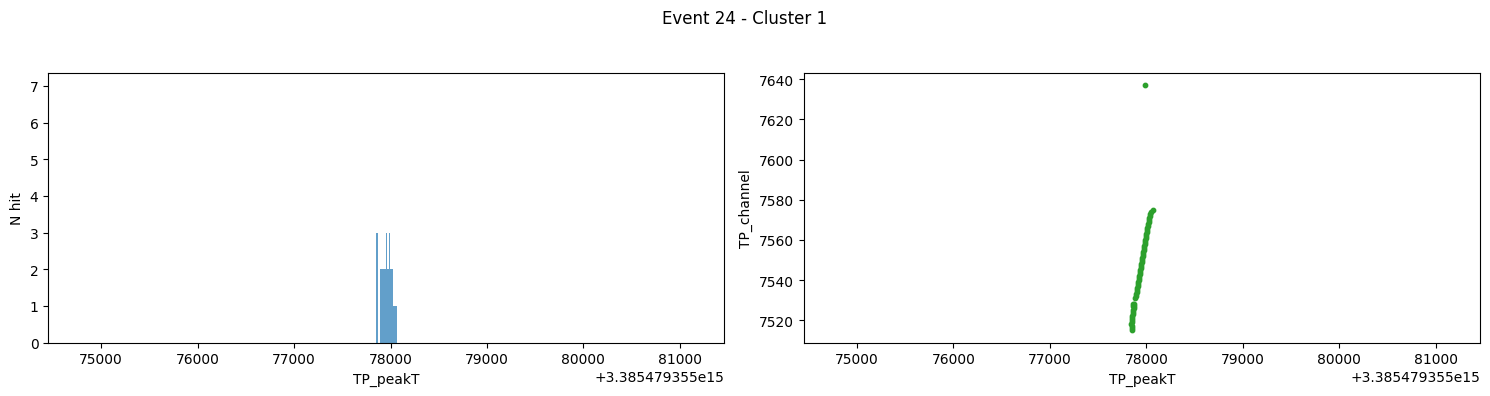

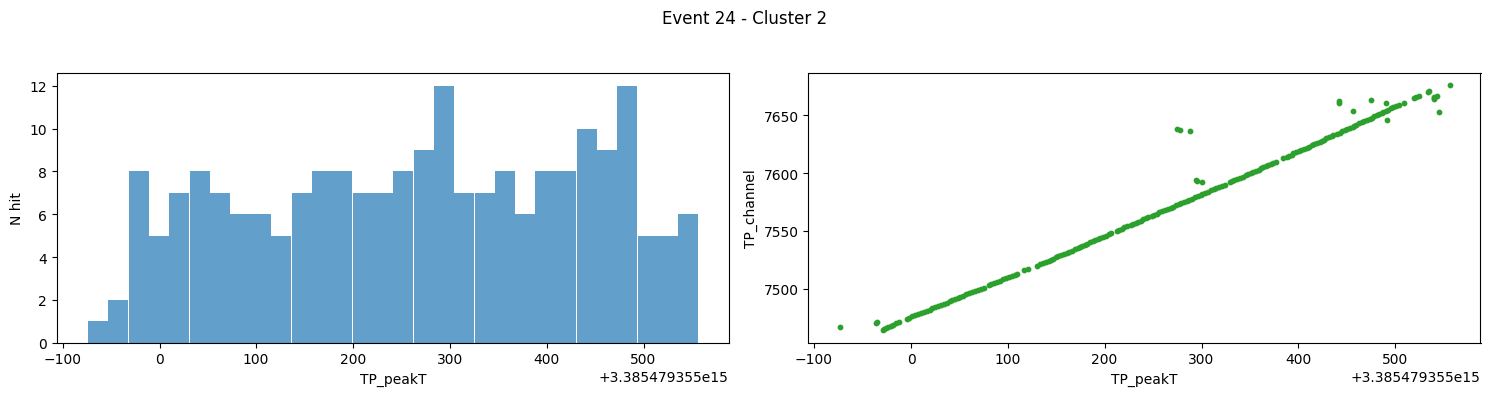

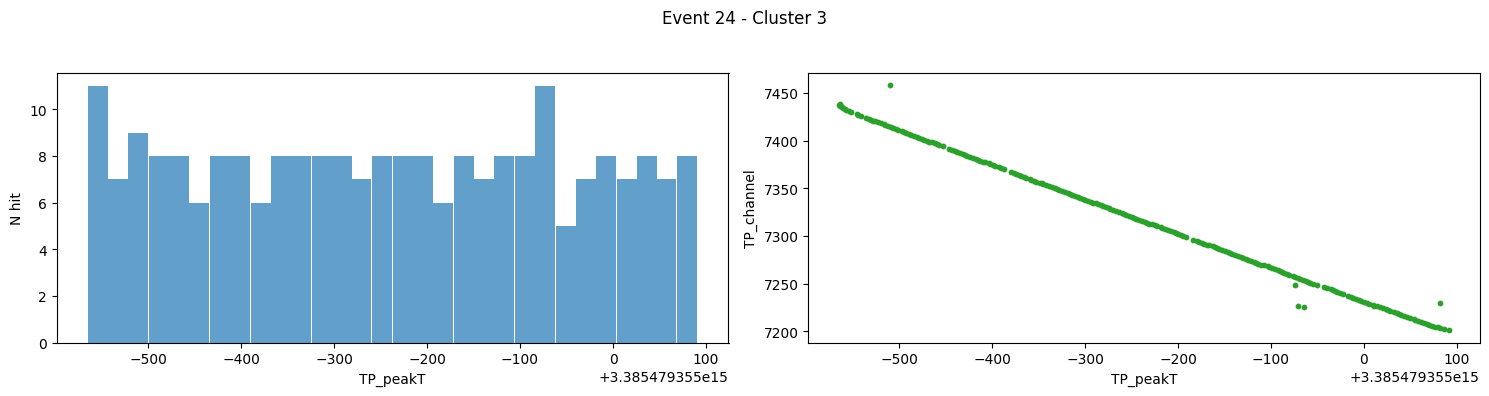

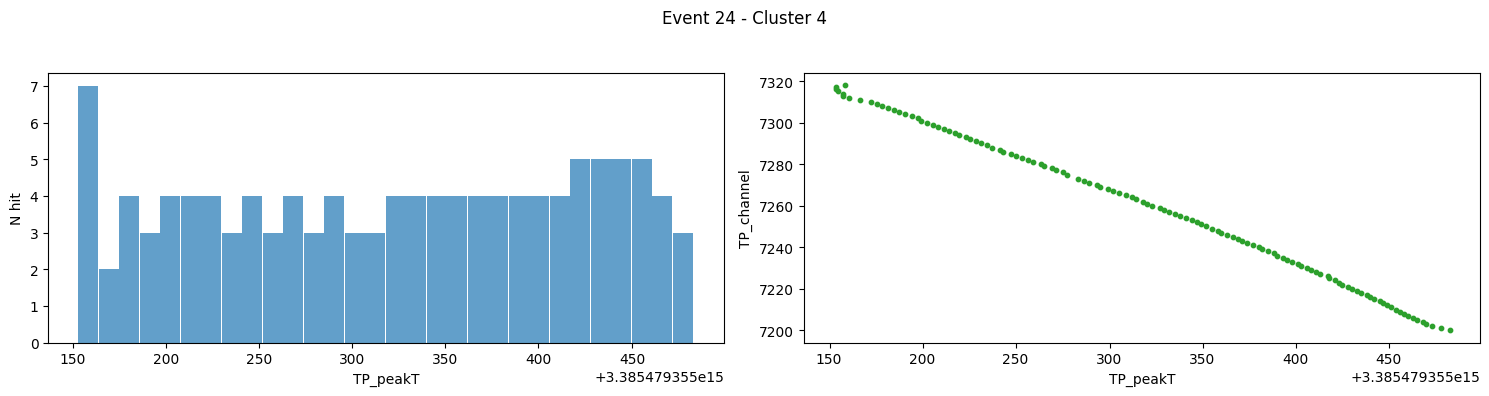

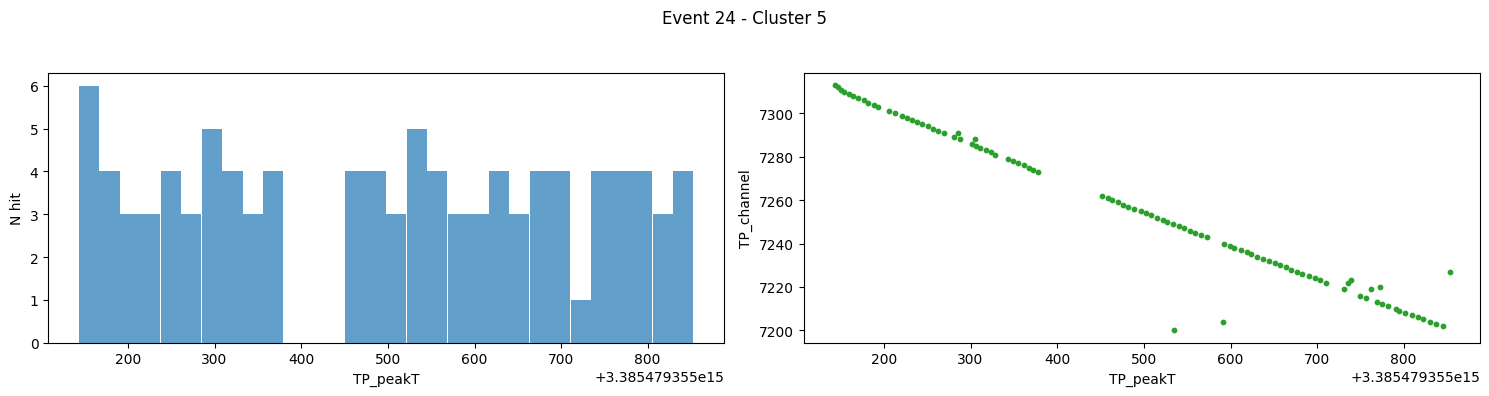

In [83]:
def plot_cluster_structure(event_df, event, cluster):
    # Filtra il cluster
    clust_df = event_df[event_df['cluster'] == cluster]
    tp_peakT = clust_df['TP_peakT']
    tp_channel = clust_df['TP_channel']

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f"Event {event} - Cluster {cluster}")

    # 1. Istogramma TP_peakT
    axs[0].hist(tp_peakT, bins=30, color='tab:blue', alpha=0.7)
    axs[0].set_xlabel('TP_peakT')
    axs[0].set_ylabel('N hit')

    # 3. Scatter TP_peakT vs TP_channel
    axs[1].scatter(tp_peakT, tp_channel, c='tab:green', s=10)
    axs[1].set_xlabel('TP_peakT')
    axs[1].set_ylabel('TP_channel')

    plt.tight_layout(rect=[0,0,1,0.94])

def analyze_clusters(df, event_col='event', cluster_col='cluster', n_events=5):
    events = df[event_col].unique()[:n_events]  # Limita a n_events per praticità
    for event in events:
        event_df = df[df[event_col] == event]
        clusters = [cl for cl in event_df[cluster_col].unique() if cl != -1]
        for cluster in clusters:
            plot_cluster_structure(event_df, event, cluster)

analyze_clusters(space_like_with_clusters, n_events=5)

Track 0: slope = -0.3521
Track 1: slope = -0.1462
Track 2: slope = 0.1490
Track 3: slope = 0.1121
Track 4: slope = 0.4706
Track 5: slope = 1.2671
Track 6: slope = -0.7303


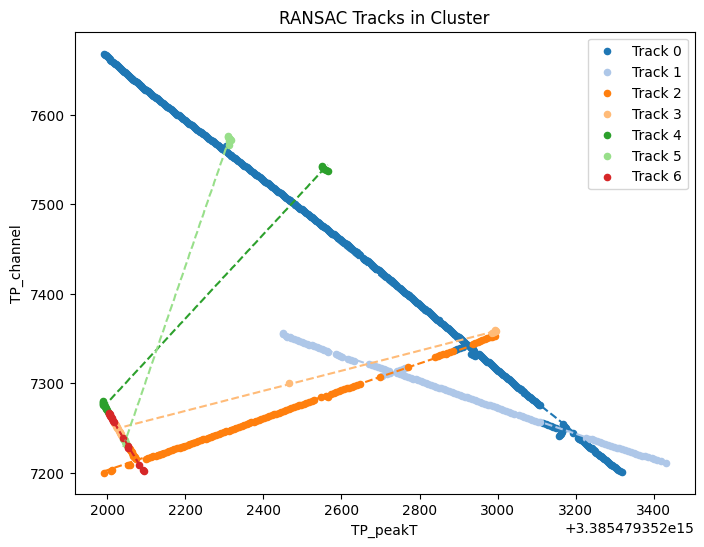

In [94]:

def ransac_tracks(cluster_df, x_col='TP_peakT', y_col='TP_channel', min_samples=10, residual_threshold=10, max_tracks=10):
    """
    Iteratively finds line-like subgroups (tracks) in cluster_df using RANSAC.
    Returns a dataframe with 'track_id', track slopes/intercepts.
    Prints slopes for each found subcluster.
    """
    df = cluster_df.copy()
    df['track_id'] = -1  # Default: not assigned
    track_results = []
    # Use positional indices
    remain_pos = np.arange(len(df))
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    track_counter = 0

    while len(remain_pos) >= min_samples and track_counter < max_tracks:
        ransac = RANSACRegressor(LinearRegression(), min_samples=min_samples, residual_threshold=residual_threshold, random_state=42)
        ransac.fit(X[remain_pos], y[remain_pos])
        inlier_mask = ransac.inlier_mask_
        n_inliers = np.sum(inlier_mask)
        if n_inliers < min_samples:
            break
        # Assign track_id to inliers
        df.iloc[remain_pos[inlier_mask], df.columns.get_loc('track_id')] = track_counter
        # Store track parameters
        slope = ransac.estimator_.coef_[0]
        intercept = ransac.estimator_.intercept_
        track_results.append({
            'track_id': track_counter,
            'slope': slope,
            'intercept': intercept,
            'n_hits': n_inliers
        })
        print(f"Track {track_counter}: slope = {slope:.4f}")  # Print the slope
        # Remove inliers for next iteration
        remain_pos = remain_pos[~inlier_mask]
        track_counter += 1
    return df, track_results

def plot_tracks(tracked_df, x_col='TP_peakT', y_col='TP_channel', track_col='track_id', track_results=None):
    plt.figure(figsize=(8,6))
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    for tid in np.unique(tracked_df[track_col]):
        if tid == -1: continue
        sel = tracked_df[tracked_df[track_col] == tid]
        plt.scatter(sel[x_col], sel[y_col], label=f'Track {tid}', s=20, color=colors[int(tid)%20])
        # Optionally plot fitted line
        if track_results is not None:
            slope = track_results[int(tid)]['slope']
            intercept = track_results[int(tid)]['intercept']
            x_fit = np.linspace(sel[x_col].min(), sel[x_col].max(), 100)
            y_fit = slope * x_fit + intercept
            plt.plot(x_fit, y_fit, color=colors[int(tid)%20], linestyle='--')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title('RANSAC Tracks in Cluster')
    plt.legend()
    plt.show()

# --- Usage Example ---
# For Event 8, Cluster 0
event = 8
cluster = 0
cluster_df = space_like_with_clusters[(space_like_with_clusters['event'] == event) &
                                      (space_like_with_clusters['cluster'] == cluster)]

tracked_df, track_results = ransac_tracks(cluster_df, x_col='TP_peakT', y_col='TP_channel',
                                          min_samples=10, residual_threshold=10)
plot_tracks(tracked_df, track_results=track_results)

Silhouette (event 8): 0.5674726785002188
Silhouette (event 16): 0.677680689652202
Silhouette (event 24): 0.5306039168743636


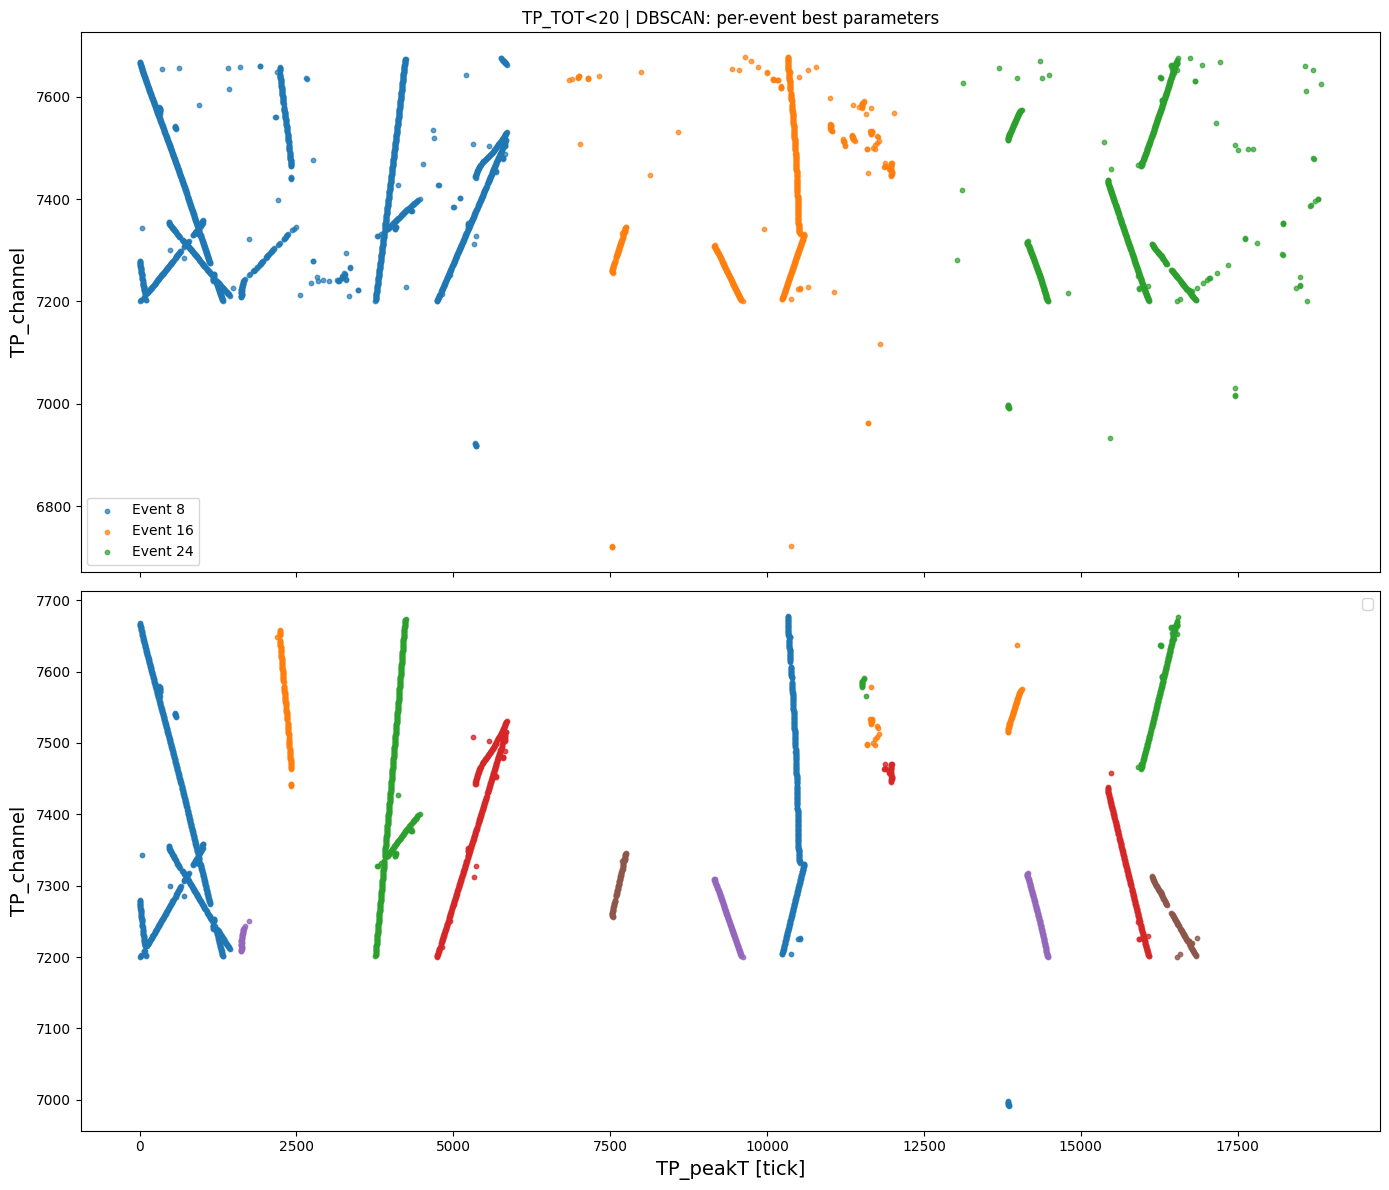

Silhouette (event 8): 0.4062427329516373
Silhouette (event 16): 0.29743943610583556
Silhouette (event 24): 0.38603804835289457


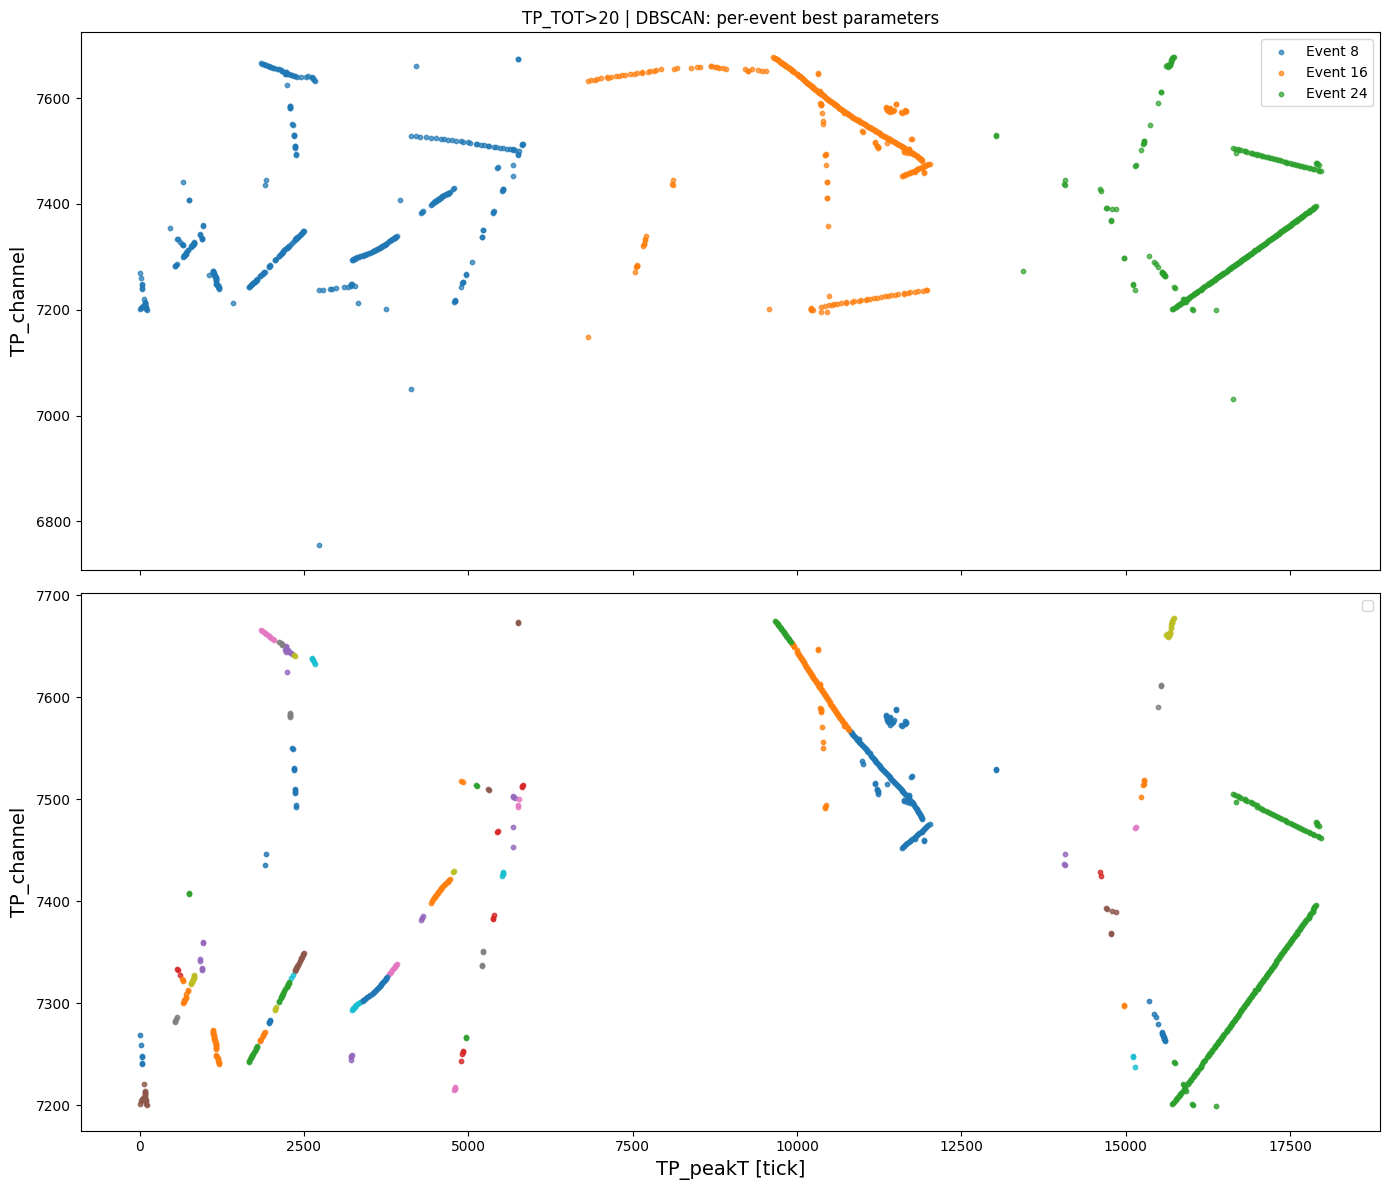

In [90]:

from sklearn.linear_model import RANSACRegressor, Ridge
events = np.unique(filtered_APA2['event'])
colors = plt.cm.tab10.colors

# --- short space tracks ---
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
offset = 0
axs[0].set_title("TP_TOT<20 | DBSCAN: per-event best parameters")

# RAW POINTS
offset = 0
for i, ev in enumerate(events):
    sel = space_like[space_like['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    axs[0].scatter(sel['TP_peakT'], sel['TP_channel'], s=10, alpha=0.7, color=colors[i % 10], label=f'Event {ev}')
    offset += tmax - tmin + 1000
axs[0].set_ylabel('TP_channel', fontsize=14)
axs[0].legend(fontsize=10)

# CLUSTERED POINTS
offset = 0
for i, ev in enumerate(events):
    sel = space_like[space_like['event'] == ev].copy()
    # Get the best parameters for this event
    event_results = results_space[results_space['event'] == ev]
    if event_results.empty or np.isnan(event_results['best_eps'].values[0]) or np.isnan(event_results['best_min_samples'].values[0]):
        continue  # skip events with no good clustering
    best_eps = event_results['best_eps'].values[0]
    best_min_samples = int(event_results['best_min_samples'].values[0])
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    X = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)
    sel['cluster'] = db.labels_
    labels = sel['cluster']
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        print(f'Silhouette (event {ev}): {metrics.silhouette_score(X, labels)}')
    else:
        print(f'Silhouette (event {ev}): N/A (only one cluster or all noise)')
    for c in np.unique(sel['cluster']):
        if c == -1: continue
        sub = sel[sel['cluster'] == c]
        axs[1].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.8, color=colors[c % 10])
    offset += tmax - tmin + 1000
axs[1].set_xlabel('TP_peakT [tick]', fontsize=14)
axs[1].set_ylabel('TP_channel', fontsize=14)
axs[1].legend(fontsize=10)
plt.tight_layout()
plt.show()

# --- long time tracks ---
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
offset = 0
axs[0].set_title("TP_TOT>20 | DBSCAN: per-event best parameters")

# RAW POINTS
offset = 0
for i, ev in enumerate(events):
    sel = time_like[time_like['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    axs[0].scatter(sel['TP_peakT'], sel['TP_channel'], s=10, alpha=0.7, color=colors[i % 10], label=f'Event {ev}')
    offset += tmax - tmin + 1000
axs[0].set_ylabel('TP_channel', fontsize=14)
axs[0].legend(fontsize=10)

# CLUSTERED POINTS
offset = 0
for i, ev in enumerate(events):
    sel = time_like[time_like['event'] == ev].copy()
    # Get the best parameters for this event
    event_results = results_time[results_time['event'] == ev]
    if event_results.empty or np.isnan(event_results['best_eps'].values[0]) or np.isnan(event_results['best_min_samples'].values[0]):
        continue  # skip events with no good clustering
    best_eps = event_results['best_eps'].values[0]
    best_min_samples = int(event_results['best_min_samples'].values[0])
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    X = sel[['TP_peakT', 'TP_channel']].values
    db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)
    sel['cluster'] = db.labels_
    labels = sel['cluster']
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        print(f'Silhouette (event {ev}): {metrics.silhouette_score(X, labels)}')
    else:
        print(f'Silhouette (event {ev}): N/A (only one cluster or all noise)')
    for c in np.unique(sel['cluster']):
        if c == -1: continue
        sub = sel[sel['cluster'] == c]
        axs[1].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.8, color=colors[c % 10])
    offset += tmax - tmin + 1000
axs[1].set_xlabel('TP_peakT [tick]', fontsize=14)
axs[1].set_ylabel('TP_channel', fontsize=14)
axs[1].legend(fontsize=10)
plt.tight_layout()
plt.show()

In [67]:
import optuna
from sklearn.linear_model import RANSACRegressor, Ridge
from scipy.stats import norm

optuna.logging.set_verbosity(optuna.logging.WARNING)

def mle_log_likelihood(X, y, model):
    y_pred = model.predict(X)
    residuals = y - y_pred
    sigma2 = np.mean(residuals**2)
    if sigma2 <= 0:
        return -np.inf
    ll = np.sum(norm.logpdf(y, loc=y_pred, scale=np.sqrt(sigma2)))
    return ll

def make_objective(X, y):
    def objective(trial):
        residual_threshold = trial.suggest_int('residual_threshold', 2, 20)
        min_points_line = trial.suggest_int('min_points_line', 8, 20)
        ridge_alpha = trial.suggest_loguniform('ridge_alpha', 0.01, 1)
        model = RANSACRegressor(
            Ridge(alpha=ridge_alpha),
            residual_threshold=residual_threshold,
            min_samples=min_points_line,
        )
        try:
            model.fit(X, y)
            inlier_mask = model.inlier_mask_
            if inlier_mask is None or np.sum(inlier_mask) < min_points_line:
                return -np.inf
            score = mle_log_likelihood(X[inlier_mask], y[inlier_mask], model.estimator_)
            return score
        except Exception:
            return -np.inf
    return objective

def get_best_ransac_params_per_event_cluster(df, event_col='event', cluster_col='cluster',
                                             x_col='TP_peakT', y_col='TP_channel',
                                             optuna_trials=60, min_cluster_points=8):
    """
    Given a dataframe df with cluster labels already assigned (in cluster_col),
    returns: event_cluster_params[event][cluster] = best RANSAC params dict from Optuna.
    """
    event_cluster_params = {}
    events = np.unique(df[event_col])
    for ev in events:
        sel_event = df[df[event_col] == ev]
        event_cluster_params[ev] = {}
        clusters = np.unique(sel_event[cluster_col])
        for c in clusters:
            if c == -1: continue  # skip noise
            sub = sel_event[sel_event[cluster_col] == c]
            X = sub[[x_col]].values
            y = sub[y_col].values
            if len(X) < min_cluster_points: continue
            objective = make_objective(X, y)
            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials=optuna_trials)
            event_cluster_params[ev][c] = study.best_trial.params
    return event_cluster_params

In [68]:
space_event_cluster_params = get_best_ransac_params_per_event_cluster(
    space_like_with_clusters, event_col='event', cluster_col='cluster',
    x_col='TP_peakT', y_col='TP_channel', optuna_trials=60, min_cluster_points=8
)

time_event_cluster_params = get_best_ransac_params_per_event_cluster(
    time_like_with_clusters, event_col='event', cluster_col='cluster',
    x_col='TP_peakT', y_col='TP_channel', optuna_trials=60, min_cluster_points=8
)


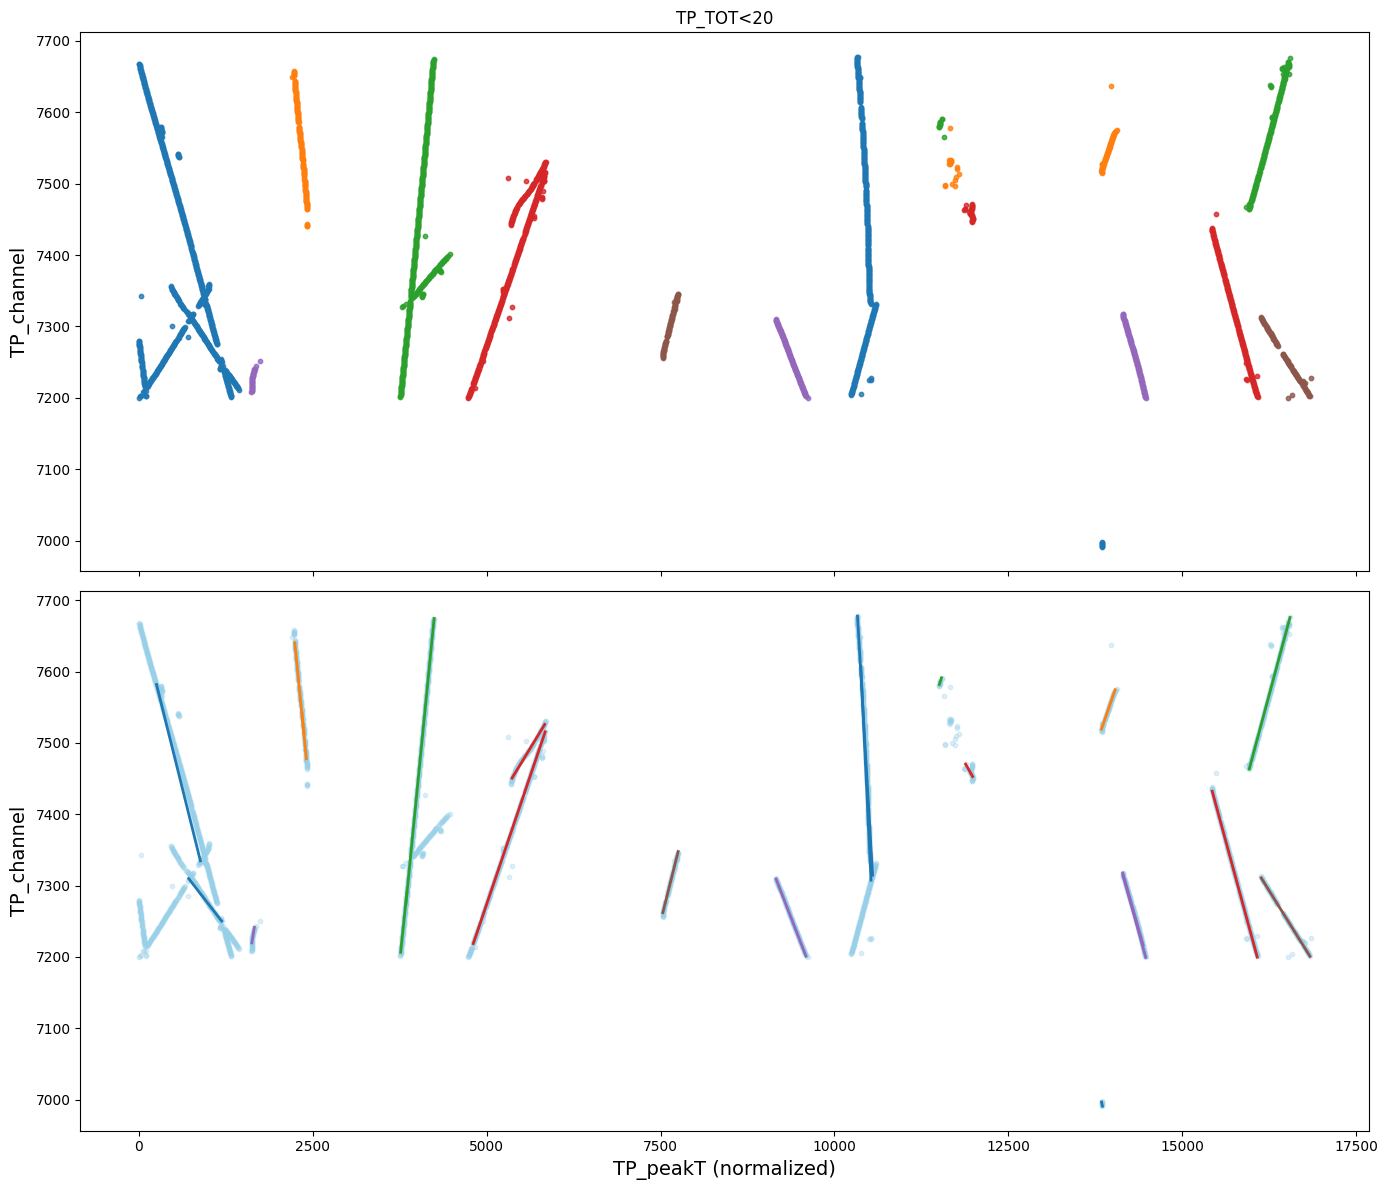

In [ ]:
# --- Example plotting using per-event, per-cluster RANSAC parameters: SPACE LIKE---

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
offset = 0
axs[0].set_title("TP_TOT<20")

events = np.unique(space_like_with_clusters['event'])
colors = plt.cm.tab10.colors

# Top panel: cluster points
offset = 0
for i, ev in enumerate(events):
    sel = space_like_with_clusters[space_like_with_clusters['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    for c in np.unique(sel['cluster']):
        if c == -1: continue  # skip noise
        sub = sel[sel['cluster'] == c]
        axs[0].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.8, color=colors[c % 10])
    offset += tmax - tmin + 1000
axs[0].set_ylabel('TP_channel', fontsize=14)

# Bottom panel: fitted tracks per cluster
offset = 0
for i, ev in enumerate(events):
    sel = space_like_with_clusters[space_like_with_clusters['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    for c in np.unique(sel['cluster']):
        if c == -1: continue
        sub = sel[sel['cluster'] == c]
        X = sub[['TP_peakT']].values
        y = sub['TP_channel'].values
        # Use per-event PER-CLUSTER Optuna params!
        params = space_event_cluster_params.get(ev, {}).get(c, None)
        if params is None: continue
        residual_threshold = params['residual_threshold']
        min_points_line = params['min_points_line']
        ridge_alpha = params['ridge_alpha']
        max_trials = 50

        pts = np.column_stack([X.flatten(), y])
        pts_remaining = pts.copy()
        color_idx = c % 10
        tracks_found = 0
        while len(pts_remaining) >= min_points_line and tracks_found < 2:
            model = RANSACRegressor(
                Ridge(alpha=ridge_alpha),
                residual_threshold=residual_threshold,
                min_samples=min_points_line,
                max_trials=max_trials,
                random_state=42
            )
            model.fit(pts_remaining[:, 0].reshape(-1, 1), pts_remaining[:, 1])
            inlier_mask = model.inlier_mask_
            if inlier_mask is None or np.sum(inlier_mask) < min_points_line:
                break
            x_in = pts_remaining[:, 0][inlier_mask]
            x_fit = np.linspace(x_in.min(), x_in.max(), 100)
            y_fit = model.predict(x_fit.reshape(-1, 1))
            axs[1].plot(x_fit, y_fit, '-', color=colors[color_idx], linewidth=2)
            pts_remaining = pts_remaining[~inlier_mask]
            tracks_found += 1
        axs[1].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.3,color="#96D0E8")
    offset += tmax - tmin + 1000

axs[1].set_xlabel('TP_peakT (normalized)', fontsize=14)
axs[1].set_ylabel('TP_channel', fontsize=14)
plt.tight_layout()
plt.show()

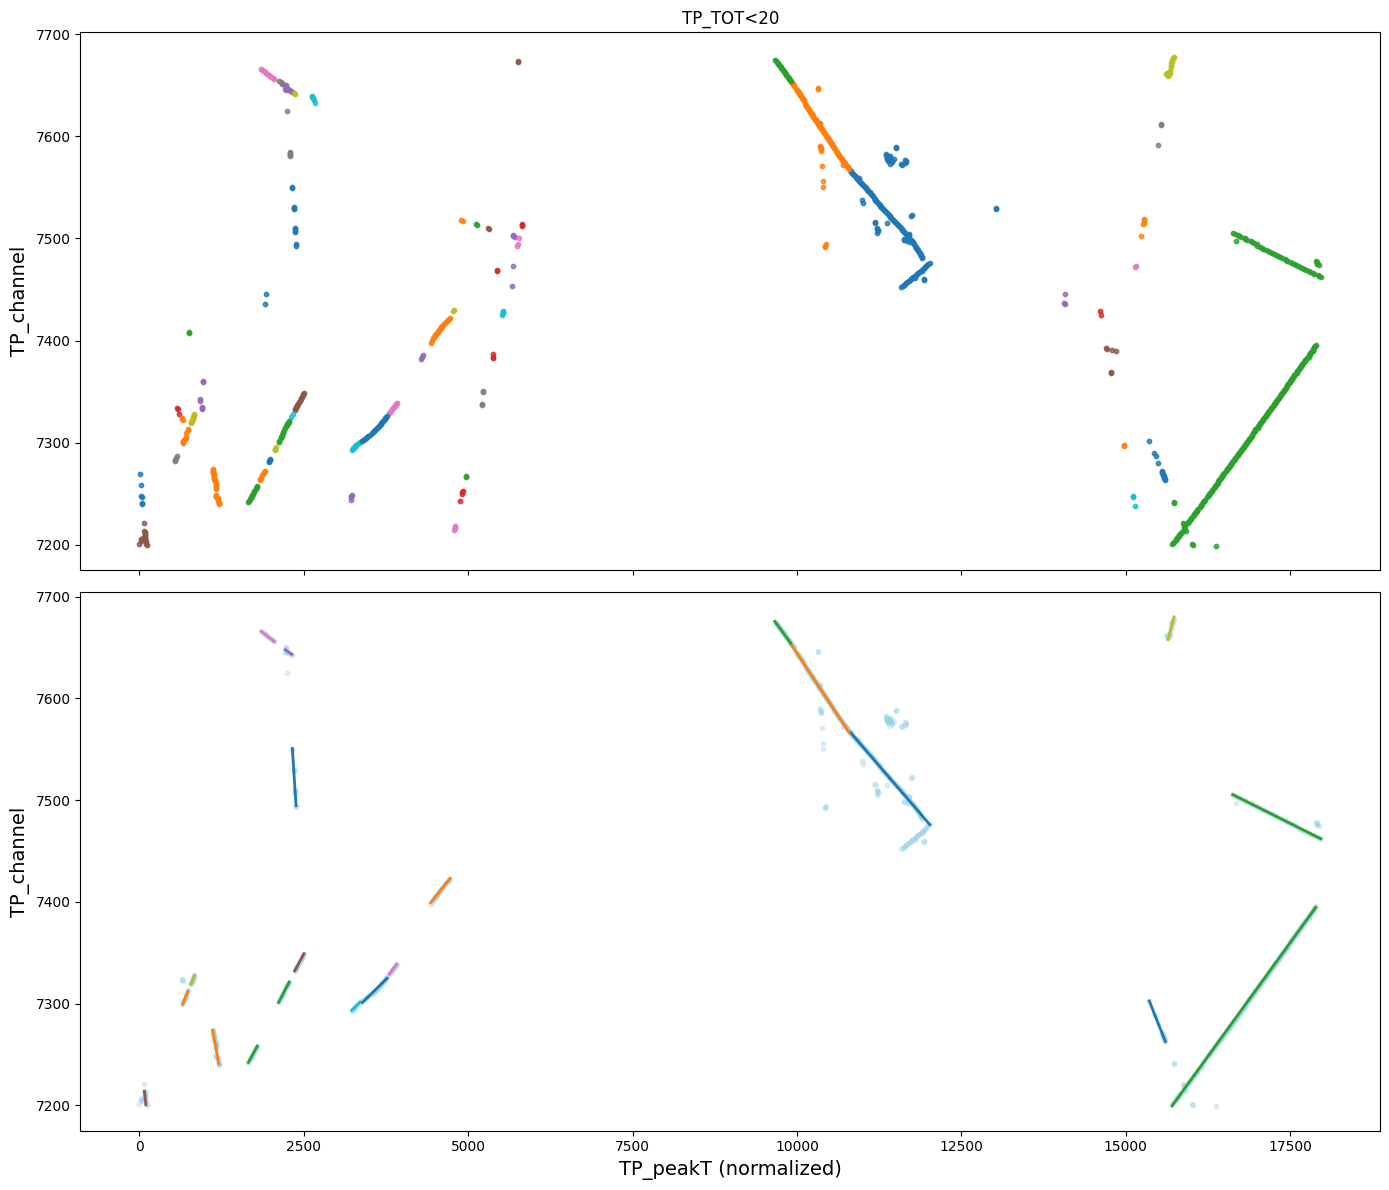

In [ ]:
# --- Example plotting using per-event, per-cluster RANSAC parameters: TIME LIKE ---
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
offset = 0
axs[0].set_title("TP_TOT<20")

events = np.unique(time_like_with_clusters['event'])
colors = plt.cm.tab10.colors

# Top panel: cluster points
offset = 0
for i, ev in enumerate(events):
    sel = time_like_with_clusters[time_like_with_clusters['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    for c in np.unique(sel['cluster']):
        if c == -1: continue  # skip noise
        sub = sel[sel['cluster'] == c]
        axs[0].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.8, color=colors[c % 10])
    offset += tmax - tmin + 1000
axs[0].set_ylabel('TP_channel', fontsize=14)

# Bottom panel: fitted tracks per cluster
offset = 0
for i, ev in enumerate(events):
    sel = time_like_with_clusters[time_like_with_clusters['event'] == ev].copy()
    sel['TP_peakT'] = sel['TP_peakT'] - sel['TP_peakT'].min() + offset
    tmin = sel['TP_peakT'].min()
    tmax = sel['TP_peakT'].max()
    for c in np.unique(sel['cluster']):
        if c == -1: continue
        sub = sel[sel['cluster'] == c]
        X = sub[['TP_peakT']].values
        y = sub['TP_channel'].values
        # Use per-event PER-CLUSTER Optuna params!
        params = time_event_cluster_params.get(ev, {}).get(c, None)
        if params is None: continue
        residual_threshold = params['residual_threshold']
        min_points_line = params['min_points_line']
        ridge_alpha = params['ridge_alpha']
        max_trials = 50

        pts = np.column_stack([X.flatten(), y])
        pts_remaining = pts.copy()
        color_idx = c % 10
        tracks_found = 0
        while len(pts_remaining) >= min_points_line and tracks_found < 2:
            model = RANSACRegressor(
                Ridge(alpha=ridge_alpha),
                residual_threshold=residual_threshold,
                min_samples=min_points_line,
            )
            model.fit(pts_remaining[:, 0].reshape(-1, 1), pts_remaining[:, 1])
            inlier_mask = model.inlier_mask_
            if inlier_mask is None or np.sum(inlier_mask) < min_points_line:
                break
            x_in = pts_remaining[:, 0][inlier_mask]
            x_fit = np.linspace(x_in.min(), x_in.max(), 100)
            y_fit = model.predict(x_fit.reshape(-1, 1))
            axs[1].plot(x_fit, y_fit, '-', color=colors[color_idx], linewidth=2)
            pts_remaining = pts_remaining[~inlier_mask]
            tracks_found += 1
        axs[1].scatter(sub['TP_peakT'], sub['TP_channel'], s=10, alpha=0.3,color="#96D0E8")
    offset += tmax - tmin + 1000

axs[1].set_xlabel('TP_peakT (normalized)', fontsize=14)
axs[1].set_ylabel('TP_channel', fontsize=14)
plt.tight_layout()
plt.show()